<a href="https://colab.research.google.com/github/Chunhao-L/ICML_Competitive-Fair-Scheduling-with-Predictions/blob/main/Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.utils import tempdir
from google.colab import files

import random
import copy
import collections
import math
import matplotlib.pyplot as plt
import numpy as np

def generate_jobs(releaseTime_lb,releaseTime_ub,jobSize_lb,jobSize_ub,job_amount,predict_error):
  randomReleaseTime = random.choices(range(releaseTime_lb,releaseTime_ub), weights=None, cum_weights=None, k=job_amount)
  randomJobSize = random.choices(range(jobSize_lb,jobSize_ub), weights=None, cum_weights=None, k=job_amount)
  for i in range(job_amount):
    ele = math.ceil(math.log(random.uniform(0, 1)) * -1 * jobSize_lb)
    if ele <= 1:
      ele = 1
    if ele > 10*jobSize_lb:
      ele = 10*jobSize_lb
    randomJobSize.append(ele)
  randomJobSize.append(100)
  J=sorted(list(zip(randomReleaseTime,randomJobSize)))
  Job_id_Counter=1
  error_bound=math.log(predict_error)
  for i in range(0,len(J)):
    error_i=random.uniform(-error_bound,error_bound)
    J[i]=[J[i][1]]+list(J[i])+[Job_id_Counter]+[error_i]
    Job_id_Counter+=1
  return J

def update_pre_err(batch_J,predict_error):
  error_bound=math.log(predict_error)
  for x in range(0,len(batch_J)):
    J=batch_J[x]
    for i in range(0,len(J)):
      error_i=random.uniform(-error_bound,error_bound)
      J[i].updatePredictError(error_i)
  return batch_J

def log_generate_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error):
  randomReleaseTime = random.choices(range(releaseTime_lb,releaseTime_ub), weights=None, cum_weights=None, k=job_amount)
  randomJobSize = []
  for i in range(job_amount):
    ele = math.ceil(- math.log(random.uniform(0, 1)) * scale_ratio)
    if ele <= 1:
      ele = 1
    randomJobSize.append(ele)
  J=sorted(list(zip(randomReleaseTime,randomJobSize)))
  Job_id_Counter=1
  error_bound=math.log(predict_error)
  for i in range(0,len(J)):
    error_i=random.uniform(-error_bound,error_bound)
    J[i]=[J[i][1]]+list(J[i])+[Job_id_Counter]+[error_i]
    Job_id_Counter+=1
  return J

def log_generate_reverse_Large_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error):
  randomReleaseTime = random.choices(range(releaseTime_lb,releaseTime_ub), weights=None, cum_weights=None, k=job_amount)
  randomJobSize = []
  for i in range(job_amount):
    ele = math.ceil(- math.log(random.uniform(0, 1)) * scale_ratio)
    if ele <= 1:
      ele = 1
    randomJobSize.append(ele)
    randomJobSize.sort(reverse=True)
  J=sorted(list(zip(randomReleaseTime,randomJobSize)))
  Job_id_Counter=1
  error_bound=math.log(predict_error)
  for i in range(0,len(J)):
    error_i=random.uniform(-error_bound,error_bound)
    J[i]=[J[i][1]]+list(J[i])+[Job_id_Counter]+[error_i]
    Job_id_Counter+=1
  return J

class Job:
  def __init__(self,i_leftSize,i_releaseTime,i_jobSize,i_jobID,i_error,i_deadline=float('inf')):
    self.leftSize=i_leftSize
    self.releaseTime=i_releaseTime
    self.jobSize=i_jobSize
    self.jobID=i_jobID
    self.deadline=i_deadline
    self.predictError=math.e**i_error
    self.predictSize=math.ceil(self.predictError*i_jobSize)
    self.completionTime = float('inf')
    self.in_alpha = 0
    self.in_beta = 0
  def updateDeadline(self,machineSpeed,stretch):
    self.deadline=self.releaseTime+self.jobSize/machineSpeed*stretch
  def calculateStretch(self,finishTime,machineSpeed):
    return (finishTime-self.releaseTime)*machineSpeed/self.jobSize
  def updatePredictDeadline(self, machineSpeed, stretch):
    self.deadline=self.releaseTime+self.predictSize/machineSpeed*stretch
  def updatePredictError(self,i_error):
    self.predictError=math.e**i_error
    self.predictSize=math.ceil(self.predictError*self.jobSize)
  def update_leftSize(self,newLeftSize):
    self.leftSize=newLeftSize
  def print_show(self):
    print("~~~")
    print("job id: ",self.jobID)
    print("release time: ", self.releaseTime)
    print("jobSize: ", self.jobSize)
    print("predict Size: ", self.predictSize)
    print("predict error: ", self.predictError)
    print("left Size: ",self.leftSize)
  def calculateResponseTime(self,finishTime):
    return finishTime-self.releaseTime

def convert_jobs(Job_lists):
  temp=[]
  for j in Job_lists:
    temp.append(Job(j[0],j[1],j[2],j[3],j[4]))
  return temp

def add_newJob(newJob,Released_Jobs,machineSpeed,stretch):
  newJob.updateDeadline(machineSpeed,stretch)
  Released_Jobs.append(newJob)

def generateBatchLogJob(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error,jobSetNum,reverseLarge=False):
  result=[]
  if reverseLarge:
    for _ in range(0,jobSetNum):
      test=log_generate_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error)
      test=convert_jobs(test)
      result.append(test)
      return result
  for _ in range(0,jobSetNum):
    test=log_generate_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error)
    test=convert_jobs(test)
    result.append(test)
  return result

def add_new_job_predict(new_job, job_list, machineSpeed, stretch):
  new_job.updatePredictDeadline(machineSpeed, stretch)
  job_list.append(new_job)

def updating_deadline(released_Jobs,machineSpeed,newStretch):
  for i in range(0,len(released_Jobs)):
    released_Jobs[i].updateDeadline(machineSpeed,newStretch)
  released_Jobs.sort(key=lambda x:x.deadline)
  return released_Jobs

def max_min_predSize(job_lists):
  l,r=float('inf'), 0
  for j in job_lists:
    l=min(l,j.predictSize)
    r=max(r,j.predictSize)
  return l,r

def max_min_Size(job_lists):
  l,r=float('inf'), 0
  for j in job_lists:
    l=min(l,j.jobSize)
    r=max(r,j.jobSize)
  return l,r

def calculate_variance(numbers):
    mean = sum(numbers) / len(numbers)
    variance = sum((x - mean) ** 2 for x in numbers) / len(numbers)
    return variance


def generate_boxplots(data_pairs, y_label, title, colors=['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']):
    fig, ax = plt.subplots()
    names, data = zip(*data_pairs)
    bplot = ax.boxplot(data, patch_artist=True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_xticklabels(names, rotation=45, fontsize=34)
    ax.set_ylabel(y_label, fontsize=34)
    ax.tick_params(axis='y', labelsize=34)
    ax.set_title(title)
    ax.yaxis.grid(True)
    plt.grid(True)
    plt.tight_layout()
    filename = f"{title} {y_label}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()

def generate_variance_bar_chart(data_input):
    categories = [pair[0] for pair in data_input]
    variances = [np.var(pair[1], ddof=1) for pair in data_input]
    plt.figure(figsize=(10, 6))
    plt.bar(categories, variances, color='skyblue')

    plt.ylabel('Variance')
    plt.show()

def plot_variance(variance_pairs):
    labels, variances = zip(*variance_pairs)
    fig, ax = plt.subplots()
    ax.bar(labels, variances, color='skyblue')
    ax.set_ylabel('Variances')
    ax.set_title('Comparison of Variances')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def min_max_normalize(data):
    all_values = [value for _, values in data for value in values]
    min_val = min(all_values)
    max_val = max(all_values)
    def normalize(value):
        return (value - min_val) / (max_val - min_val) if max_val > min_val else value
    normalized_data=[(name,[normalize(value) for value in values]) for name,values in data]
    return normalized_data


def valid_releasedJob_deadline(current_time,Released_Jobs,machineSpeed):
  t=current_time
  for j in Released_Jobs:
    leftProcessingTime=j.leftSize/machineSpeed
    t+=leftProcessingTime
    if t>j.deadline:
      return False
  return True

def find_stretch_so_far(All_Job_SoFar,currentStretch,machineSpeed):
  valid_releasedJob_deadline(0,All_Job_SoFar,machineSpeed)
  if valid_releasedJob_deadline(0,All_Job_SoFar,machineSpeed):
    return currentStretch
  else:
    l,r=currentStretch,10*currentStretch
    tempJobSet=copy.copy(All_Job_SoFar)
    while r >= l:
      mid = (l+r)//2
      updating_deadline(tempJobSet,machineSpeed,mid)
      x = valid_releasedJob_deadline(0,tempJobSet,machineSpeed)
      if l==r:
        if x:
          return r
        else:
          break
      elif x:
        r=mid
      else:
        l=mid+1
    return find_stretch_so_far(All_Job_SoFar,currentStretch*10+1,machineSpeed)

def single_ssf_stretch_finder(current_time,released_job,currentStretch,machineSpeed):
  t=current_time
  l,r=currentStretch,10*currentStretch
  tempJobSet=copy.copy(released_job)
  while r >= l:
    mid = (l+r)//2
    updating_deadline(tempJobSet,machineSpeed,mid)
    x = valid_releasedJob_deadline(t,tempJobSet,machineSpeed)
    if l==r:
      if x:
        return r
      else:
        break
    elif x:
      r=mid
    else:
      l=mid+1
  return single_ssf_stretch_finder(t,released_job,currentStretch*10+1)

In [ ]:
#single machine edf no interreption execution
#return max-stretch during this period
def EDF_singleMachine_execution_noInterreption(jobs,CurrentTime,FinishTime,machineSpeed)->int:
  tempS=1
  equal_processing_capacity=machineSpeed*(FinishTime-CurrentTime)
  t=CurrentTime
  while equal_processing_capacity:
    if jobs==[]:
      return tempS
    elif jobs[0].leftSize<=equal_processing_capacity:
      equal_processing_capacity-=jobs[0].leftSize
      newFinish=jobs.pop(0)
      t+=newFinish.leftSize/machineSpeed
      newS=newFinish.calculateStretch(t,machineSpeed)
      tempS=max(tempS,newS)
    else:
      jobs[0].leftSize-=equal_processing_capacity
      return tempS
  return 1

#semi-Clairvoyant: scheduler know job size upon its release but no aware of future job
#return Max-Stretch
def SSF_EDF_semiClairvoyant(assigned_jobs,machineSpeed):
  t=0
  released_jobs=[] #including only unfinished jobs
  All_Released_Jobs=[] #including all jobs, unexecuted, from 0 to now
  stretch=1
  actualStretch=1
  while assigned_jobs:
    newjob=assigned_jobs.pop(0)
    o_newjob=copy.deepcopy(newjob)
    t=newjob.releaseTime
    add_newJob(newjob,released_jobs,machineSpeed,stretch)
    add_newJob(o_newjob,All_Released_Jobs,machineSpeed,stretch)
    released_jobs.sort(key=lambda x:x.deadline)
    All_Released_Jobs.sort(key=lambda x:x.deadline)
    if not valid_releasedJob_deadline(0,All_Released_Jobs,machineSpeed):
      stretch=find_stretch_so_far(All_Released_Jobs,stretch,machineSpeed)
      updating_deadline(released_jobs,machineSpeed,stretch)
      updating_deadline(All_Released_Jobs,machineSpeed,stretch)
    finish_time=float('inf')
    if assigned_jobs:
      finish_time=assigned_jobs[0].releaseTime
    newS=EDF_singleMachine_execution_noInterreption(released_jobs,t,finish_time,machineSpeed)
    actualStretch=max(newS,actualStretch)
  return actualStretch,stretch


In [ ]:
#single machine rr no interreption execution
#return max-stretch during this period
def rr_singleMachine_execution_noInterreption(jobs,CurrentTime,FinishTime,machineSpeed)->int:
  tempS=1
  stretchRecord=[]
  resTimeRecord=[]
  equal_processing_capacity=machineSpeed*(FinishTime-CurrentTime)
  t=CurrentTime
  jobs.sort(key=lambda x:x.leftSize,reverse=True)
  left_num=len(jobs)
  while equal_processing_capacity:
    if jobs==[]:
      return stretchRecord,resTimeRecord
    elif jobs[-1].leftSize*left_num<=equal_processing_capacity:
      equal_processing_capacity-=jobs[-1].leftSize*left_num
      newFinish=jobs.pop()
      t+=newFinish.leftSize*left_num/machineSpeed
      for i in range(0,len(jobs)):
        jobs[i].leftSize-=newFinish.leftSize
      newS=newFinish.calculateStretch(t,machineSpeed)
      newRes=t-newFinish.releaseTime
      tempS=max(tempS,newS)
      left_num-=1
      stretchRecord.append(newS)
      resTimeRecord.append(newRes)
    else:
      average_p=equal_processing_capacity/left_num
      for i in range(0,len(jobs)):
        jobs[i].leftSize-=equal_processing_capacity/left_num
      return stretchRecord,resTimeRecord
  return stretchRecord,resTimeRecord

#single machine rr
#return max-stretch during this period
def rr(assigned_jobs,machineSpeed)-> int:
  t=0
  released_jobs=[] #including only unfinished jobs
  actualStretch=1
  allStretchRecord=[]
  allResTimeRecord=[]
  while assigned_jobs:
    newjob=assigned_jobs.pop(0)
    o_newjob=copy.deepcopy(newjob)
    t=newjob.releaseTime
    released_jobs.append(o_newjob)
    released_jobs.sort(key=lambda x:x.leftSize,reverse=True)
    finish_time=float('inf')
    if assigned_jobs:
      finish_time=assigned_jobs[0].releaseTime
    newStretchsThisExe,newResTimeThisExe=rr_singleMachine_execution_noInterreption(released_jobs,t,finish_time,machineSpeed)
    allStretchRecord+=newStretchsThisExe
    allResTimeRecord+=newResTimeThisExe
  if len(released_jobs):
    newStretchsThisExe,newResTimeThisExe=rr_singleMachine_execution_noInterreption(released_jobs,t,float('inf'),machineSpeed)
    allStretchRecord+=newStretchsThisExe
    allResTimeRecord+=newResTimeThisExe
  actualStretch=max(allStretchRecord)
  return actualStretch,calculate_variance(allStretchRecord),sum(allResTimeRecord)/len(allResTimeRecord)

In [ ]:
#Relaxed Greedy New
from collections import deque
def relaxed_greedy(assigned_jobs,machineSpeed):
  def relaxed_greedy_job_release(threshold_a,small_job_deque,big_job_deque,new_job):
    if new_job.predictSize <= threshold_a:
      small_job_deque.append(new_job)
    else:
      big_job_deque.append(new_job)
  def relaxed_greedy_job_choose(small_job_deque,big_job_deque,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_deque):
      small_release_t=small_job_deque[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_deque):
      big_release_t=big_job_deque[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=None
    if flag==1:
      target_job=small_job_deque[0]
    elif flag==2:
      target_job=big_job_deque[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      if flag==1:small_job_deque.popleft()
      if flag==2:big_job_deque.popleft()
      return target_job_finish_time #return the job completion time
    else:
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def relaxed_greedy_execution(small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,tr_a,tr_b,resTime_record):
    temp_t=current_t
    while temp_t<finish_t:
      flag=relaxed_greedy_job_choose(small_job_deque,big_job_deque,temp_t,tr_a,tr_b)
      if flag==0:
        break
      else:
        temp_t=relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,temp_t,finish_t,machine_speed,stretch_record,resTime_record)
  t=0
  p_min,p_max=max_min_predSize(assigned_jobs)
  a,b=math.sqrt(p_min*p_max)/math.sqrt(3),p_max
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=deque(),deque()
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    relaxed_greedy_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    relaxed_greedy_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,stretch_Records,a,b,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)




In [ ]:
#Adaptive Relaxed Greedy
#the range of pmin_error_ratio should be +- 1 to \lambda
from collections import deque
def adaptive_relaxed_greedy(assigned_jobs,machineSpeed,pmin_error_ratio):
  def adaptive_relaxed_greedy_job_release(threshold_a,small_job_deque,big_job_deque,new_job):
    if new_job.predictSize <= threshold_a:
      small_job_deque.append(new_job)
    else:
      big_job_deque.append(new_job)
  def adaptive_relaxed_greedy_job_choose(small_job_deque,big_job_deque,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_deque):
      small_release_t=small_job_deque[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_deque):
      big_release_t=big_job_deque[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def adaptive_relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=None
    if flag==1:
      target_job=small_job_deque[0]
    elif flag==2:
      target_job=big_job_deque[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      if flag==1:small_job_deque.popleft()
      if flag==2:big_job_deque.popleft()
      return target_job_finish_time
    else:
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def adaptive_relaxed_greedy_execution(small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,tr_a,tr_b,resTime_record):
    temp_t=current_t
    while temp_t<finish_t:
      flag=adaptive_relaxed_greedy_job_choose(small_job_deque,big_job_deque,temp_t,tr_a,tr_b)
      if flag==0:
        break
      else:
        temp_t=adaptive_relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,temp_t,finish_t,machine_speed,stretch_record,resTime_record)

  t=0
  p_min,_=max_min_predSize(assigned_jobs)
  p_max=-1
  if pmin_error_ratio<0:
    p_min=p_min/(-pmin_error_ratio)
  elif pmin_error_ratio>0:
    p_min=p_min*pmin_error_ratio
  a,b=None,None
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=deque(),deque()
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    if newjob.predictSize>p_max:
      p_max=newjob.predictSize
      a,b=math.sqrt(p_min*p_max)/math.sqrt(3),p_max
    adaptive_relaxed_greedy_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    adaptive_relaxed_greedy_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,stretch_Records,a,b,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)

In [ ]:
#Greedy with Rounding

def greedy_with_rounding(assigned_jobs,machineSpeed):
  def greedy_with_rounding_job_release(threshold_a,small_job_deque,big_job_deque,new_job):
    if new_job.jobSize <= threshold_a:
      small_job_deque.append(new_job)
    else:
      big_job_deque.append(new_job)
  def greedy_with_rounding_job_choose(small_job_deque,big_job_deque,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_deque):
      small_release_t=small_job_deque[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_deque):
      big_release_t=big_job_deque[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def greedy_with_rounding_execu_single_selected_job(flag,small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=None
    if flag==1:
      target_job=small_job_deque[0]
    elif flag==2:
      target_job=big_job_deque[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      if flag==1:small_job_deque.popleft()
      if flag==2:big_job_deque.popleft()
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def greedy_with_rounding_execution(small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,tr_a,tr_b,resTime_record):
    temp_t=current_t
    while temp_t<finish_t:
      flag=greedy_with_rounding_job_choose(small_job_deque,big_job_deque,temp_t,tr_a,tr_b)
      if flag==0:
        break
      else:
        temp_t=greedy_with_rounding_execu_single_selected_job(flag,small_job_deque,big_job_deque,temp_t,finish_t,machine_speed,stretch_record,resTime_record)
  t=0
  ac_min,ac_max=max_min_Size(assigned_jobs)
  a,b=math.sqrt(ac_max/ac_min),ac_max/ac_min
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=deque(),deque()
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    greedy_with_rounding_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    greedy_with_rounding_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,stretch_Records,a,b,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)


In [ ]:
#Shortest Remaining Time First

from collections import deque
def SRPT(assigned_jobs,machineSpeed):
  def SRPT_job_release(released_job,new_job):
    released_job.append(new_job)
    released_job.sort(key=lambda x:x.leftSize)

  def SRPT_execu_single_selected_job(released_job,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=released_job[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      released_job.pop(0)
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def SRPT_execution(released_job,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    temp_t=current_t
    while released_job and temp_t<finish_t:
      temp_t=SRPT_execu_single_selected_job(released_job,temp_t,finish_t,machine_speed,stretch_record,resTime_record)
  t=0
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  released_job=[]
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    SRPT_job_release(released_job,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    SRPT_execution(released_job,t,next_t,machineSpeed,stretch_Records,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)


In [ ]:
#RR-Augmentated Relaxed_Greedy
from collections import deque
def augmentated_relaxed_greedy(assigned_jobs,machineSpeed,augmentSpeed):
  def cal_other_remain(small_job_arr,big_job_arr,workload,this_t,stretch_record,resTime_record,machine_speed):
    i=len(small_job_arr)-1
    while i>=0:
      small_job_arr[i].update_leftSize(small_job_arr[i].leftSize-workload)
      if small_job_arr[i].leftSize<=0.00000000001:
        target_job=small_job_arr[i]
        stretch_record.append(target_job.calculateStretch(this_t,max(1,machine_speed)))
        resTime_record.append(target_job.calculateResponseTime(this_t))
        del small_job_arr[i]
      i-=1
    i=len(big_job_arr)-1
    while i>=0:
      big_job_arr[i].update_leftSize(big_job_arr[i].leftSize-workload)
      if big_job_arr[i].leftSize<=0.00000000001:
        target_job=big_job_arr[i]
        stretch_record.append(target_job.calculateStretch(this_t,machine_speed))
        resTime_record.append(target_job.calculateResponseTime(this_t))
        del big_job_arr[i]
      i-=1
  def next_rr(small_job_arr,big_job_arr,machineSpeed):
    total_j=len(small_job_arr)+len(big_job_arr)
    if machineSpeed<=0:return float('inf'),total_j
    min_j_size=float('inf')
    for j in small_job_arr:
      if j.leftSize<min_j_size:
        min_j_size=j.leftSize
    for j in big_job_arr:
      if j.leftSize<min_j_size:
        min_j_size=j.leftSize
    return min_j_size*total_j/machineSpeed,total_j #return next possible rr event time and # of current jobs
  def augmentated_relaxed_greedy_job_release(threshold_a,small_job_arr,big_job_arr,new_job):
    if new_job.predictSize <= threshold_a:
      small_job_arr.append(new_job)
    else:
      big_job_arr.append(new_job)
  def augmentated_relaxed_greedy_job_choose(small_job_arr,big_job_arr,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_arr):
      small_release_t=small_job_arr[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_arr):
      big_release_t=big_job_arr[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def augmentated_relaxed_greedy_execu_single_selected_job(flag,small_job_arr,big_job_arr,current_t,this_finish_t,machine_speed,augment_speed,stretch_record,resTime_record,job_amount):
    target_job=None
    rr_speed=machine_speed/job_amount
    if flag==1:
      target_job=small_job_arr[0]
    elif flag==2:
      target_job=big_job_arr[0]
    time_needed=target_job.leftSize/(rr_speed+augment_speed)
    available_time=this_finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,max(1,machine_speed))
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      if flag==1:small_job_arr.pop(0)
      if flag==2:big_job_arr.pop(0)
      rr_load=time_needed*rr_speed
      cal_other_remain(small_job_arr,big_job_arr,rr_load,target_job_finish_time,stretch_record,resTime_record,machine_speed)
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=augment_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      rr_load=available_time*rr_speed
      cal_other_remain(small_job_arr,big_job_arr,rr_load,this_finish_t,stretch_record,resTime_record,machine_speed)
      return this_finish_t
  def augmentated_relaxed_greedy_execution(small_job_arr,big_job_arr,current_t,finish_t,machine_speed,augment_speed,stretch_record,tr_a,tr_b,resTime_record):
    temp_t=current_t
    while temp_t<finish_t:
      flag=augmentated_relaxed_greedy_job_choose(small_job_arr,big_job_arr,temp_t,tr_a,tr_b)
      if flag==0:
        break
      else:
        rr_t,job_amount=next_rr(small_job_arr,big_job_arr,machine_speed)
        event_t=temp_t+rr_t
        next_t=min(finish_t,event_t)
        temp_t=augmentated_relaxed_greedy_execu_single_selected_job(flag,small_job_arr,big_job_arr,temp_t,next_t,machine_speed,augment_speed,stretch_record,resTime_record,job_amount)
  t=0
  p_min,p_max=max_min_predSize(assigned_jobs)
  a,b=math.sqrt(p_min*p_max)/math.sqrt(3),p_max
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=[],[]
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    augmentated_relaxed_greedy_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    augmentated_relaxed_greedy_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,augmentSpeed,stretch_Records,a,b,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)

In [ ]:
#Greedy with Rounding
import math
import sys
current_running_Time = 0
short_released_jobs = [] #short job released but unfinished at time t
long_released_jobs = [] #long job released but unfinished at time t
running_job_type = ''
max_stretch = 0.0
counter  = 0

class Event:
  def __init__(self,i_eventTime,i_eventType):
    self.eventTime=i_eventTime
    self.eventType=i_eventType

def GreedyStertch(in_job, currentTime, alpha, beta):
  if in_job.completionTime < currentTime:
    currentTime = in_job.completionTime
  if in_job.predictSize <= alpha:
    return (currentTime-in_job.releaseTime)/alpha
  else:
    return (currentTime-in_job.releaseTime)/beta

def JobRelease_GR(currentTime, event_list, all_jobs, alpha, beta):
  global running_job_type
  new_job = all_jobs.pop(0)
  new_job.leftSize = new_job.jobSize
  o_new_job = copy.deepcopy(new_job)
  job_stretch = GreedyStertch(new_job, currentTime,alpha,beta)
  if new_job.predictSize <= alpha:
    add_new_job_predict(new_job,short_released_jobs, 1, job_stretch)
  else:
    add_new_job_predict(new_job,long_released_jobs,1, job_stretch)

  if len(short_released_jobs) == 1 and len(long_released_jobs) == 0:
    e = Event(currentTime + new_job.jobSize, 1)
    event_list.append(e)
    running_job_type = 'short'

  if len(short_released_jobs) == 0 and len(long_released_jobs) == 1:
    e = Event(currentTime + new_job.jobSize, 1)
    event_list.append(e)
    running_job_type = 'long'

  if all_jobs:
    next_release_event = Event(all_jobs[0].releaseTime, 0)
    event_list.append(next_release_event)
  event_list.sort(key=lambda x:x.eventTime)


def JobComplete_GR(currentTime, event_list,all_released_jobs,alpha,beta):
  global running_job_type
  global max_stretch
  global counter
  counter = counter + 1
  if running_job_type == 'short':
    c_job = short_released_jobs.pop(0)
    all_released_jobs[c_job.jobID -1].completionTime = currentTime
    all_released_jobs[c_job.jobID -1].leftSize = 0
    all_released_jobs[c_job.jobID -1].stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
    if max_stretch < (currentTime - c_job.releaseTime)/c_job.jobSize:
      max_stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
  else:
    c_job = long_released_jobs.pop(0)
    all_released_jobs[c_job.jobID -1].completionTime = currentTime
    all_released_jobs[c_job.jobID -1].leftSize = 0
    all_released_jobs[c_job.jobID -1].stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
    if max_stretch < (currentTime - c_job.releaseTime)/c_job.jobSize:
      max_stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
  if short_released_jobs and long_released_jobs:
    if GreedyStertch(short_released_jobs[0], currentTime,alpha,beta) >= GreedyStertch(long_released_jobs[0], currentTime,alpha,beta):
      next_complete_event = Event(currentTime + short_released_jobs[0].leftSize, 1)
      event_list.append(next_complete_event)
      running_job_type = 'short'
    elif GreedyStertch(short_released_jobs[0], currentTime,alpha,beta) < GreedyStertch(long_released_jobs[0], currentTime,alpha,beta):
      next_complete_event = Event(currentTime + long_released_jobs[0].leftSize, 1)
      event_list.append(next_complete_event)
      running_job_type = 'long'

  elif short_released_jobs:
    next_complete_event = Event(currentTime + short_released_jobs[0].leftSize, 1)
    event_list.append(next_complete_event)
    running_job_type = 'short'
  elif long_released_jobs:
    next_complete_event = Event(currentTime + long_released_jobs[0].leftSize, 1)
    event_list.append(next_complete_event)
    running_job_type = 'long'
  event_list.sort(key=lambda x:x.eventTime)

def GreedyWithRounding(target_jobs):
  global running_job_type
  global current_running_Time
  all_jobs=target_jobs
  next_release_time = sys.maxsize
  next_complete_time = sys.maxsize
  job_switch_time = sys.maxsize
  events = []
  e1 = Event(all_jobs[0].releaseTime, 0)
  events.append(e1)
  p_min, p_max = max_min_Size(target_jobs)
  alpha,beta=math.sqrt(p_max/p_min),p_max/p_min
  all_released_jobs=copy.deepcopy(target_jobs)
  while(events):
    crnt_event = events.pop(0);
    current_running_Time = crnt_event.eventTime

    if crnt_event.eventType == 0:
      JobRelease_GR(current_running_Time, events, target_jobs,alpha,beta)
    elif crnt_event.eventType == 1:
      JobComplete_GR(current_running_Time, events,all_released_jobs,alpha,beta)
  return max_stretch

In [ ]:
#batch test
def batch_test(BatchSet,machineSpeed=1,boostSpeed=0):
  GWR_RS,RG_RS,ARG_RS,RR_RS=[],[],[],[]
  GWR_variances,rg_variances,arg_variances,rr_variances=[],[],[],[]
  GWR_RES,RG_RES,ARG_RES,RR_RES=[],[],[],[]
  RR_RG_RS,RR_RG_variances,RR_RG_RES=[],[],[]
  SSF_RS,SSF_variances,SSF_RES=[],[],[]
  SRPT_RS,SRPT_variances,SRPT_RES=[],[],[]
  for test in BatchSet:
    opt_test=copy.deepcopy(test)
    updating_deadline(opt_test,1,1)
    opt_stretch=find_stretch_so_far(opt_test,1,1)
    bi_search_stretch=opt_stretch

    rr_test=copy.deepcopy(test)
    rr_test.sort(key=lambda x:x.releaseTime)
    rr_stretch,rr_variance,rr_restime=rr(rr_test,1)
    #RR actual stretch

    RG_test=copy.deepcopy(test)
    RG_test.sort(key=lambda x:x.releaseTime)
    rg_stretch,rg_variance,rg_restime=relaxed_greedy(RG_test,machineSpeed)
    #Relaxed greedy

    ARG_test=copy.deepcopy(test)
    ARG_test.sort(key=lambda x:x.releaseTime)
    arg_stretch,arg_variance,arg_restime=adaptive_relaxed_greedy(ARG_test,machineSpeed,1)
    #adaptive Relaxed greedy

    GWR_test=copy.deepcopy(test)
    GWR_test.sort(key=lambda x:x.releaseTime)
    GWR_stretch,GWR_variance,GWR_restime=greedy_with_rounding(GWR_test,machineSpeed)
    #greedy with rounding new

    RR_RG_test=copy.deepcopy(test)
    RR_RG_test.sort(key=lambda x:x.releaseTime)
    RR_RG_stretch,RR_RG_variance,RR_RG_restime=augmentated_relaxed_greedy(RR_RG_test,boostSpeed,machineSpeed)
    #RR ARGUMENTED

    SRPT_test=copy.deepcopy(test)
    SRPT_test.sort(key=lambda x:x.releaseTime)
    SRPT_stretch,SRPT_variance,SRPT_restime=SRPT(SRPT_test,machineSpeed)
    SRPT_ratio=SRPT_stretch/bi_search_stretch
    SRPT_RS.append(SRPT_ratio)
    SRPT_variances.append(SRPT_variance)
    SRPT_RES.append(SRPT_restime)
    #SRPT


    GWR_ratio,RG_ratio,ARG_ratio,RR_ratio=GWR_stretch/bi_search_stretch, rg_stretch/bi_search_stretch,arg_stretch/bi_search_stretch, rr_stretch/bi_search_stretch
    RR_RG_ratio=RR_RG_stretch/bi_search_stretch
    #greedy with rounding new,                relaxed greedy,     adaptive relaxed greedy,       rr
    GWR_RS.append(GWR_ratio)
    RG_RS.append(RG_ratio)
    ARG_RS.append(ARG_ratio)
    RR_RS.append(RR_ratio)
    RR_RG_RS.append(RR_RG_ratio)
    #print(GWR_ratio, ", ", RG_ratio, ", ",ARG_ratio, ", ", RR_ratio)
    GWR_variances.append(GWR_variance)
    rg_variances.append(rg_variance)
    arg_variances.append(arg_variance)
    rr_variances.append(rr_variance)
    RR_RG_variances.append(RR_RG_variance)
    #AVERAGE RESPONSE TIME
    GWR_RES.append(GWR_restime/SRPT_restime)
    RG_RES.append(rg_restime/SRPT_restime)
    ARG_RES.append(arg_restime/SRPT_restime)
    RR_RES.append(rr_restime/SRPT_restime)
    RR_RG_RES.append(RR_RG_restime/SRPT_restime)

  result_pairs= [
      ("GWR", GWR_RS),
      ("RG", RG_RS),
      ("ARG", ARG_RS),
      ("RR",RR_RS),
      ("RG+",RR_RG_RS),
      # ("SRPT",SRPT_RS)
  ]
  variance_pairs= [
      ("GWR", GWR_variances),
      ("RG", rg_variances),
      ("ARG", arg_variances),
      ("RR",rr_variances),
      ("RG+",RR_RG_variances),
      # ("SRPT",SRPT_variances)
  ]
  resTime_pairs= [
      ("GWR", GWR_RES),
      ("RG", RG_RES),
      ("ARG", ARG_RES),
      ("RR",RR_RES),
      ("RG+",RR_RG_RES),
      # ("SRPT",SRPT_RES)
  ]
  variance_pairs=min_max_normalize(variance_pairs)
  print("Performance ratio")
  print(result_pairs)
  print("variance")
  print(variance_pairs)
  print("Average Response time")
  print(resTime_pairs)
  generate_boxplots(result_pairs,"Performance Ratio","")
  generate_boxplots(variance_pairs,"Variance","")
  generate_boxplots(resTime_pairs,"Performance Ratio\n(Response Time)","")



In [ ]:
def batch_record(x_value,S_Data,V_Data,R_Data,BatchSet,machineSpeed=1,boostSpeed=0):
  GWR_RS,RG_RS,ARG_RS,RR_RS=[],[],[],[]
  GWR_variances,rg_variances,arg_variances,rr_variances=[],[],[],[]
  GWR_RES,RG_RES,ARG_RES,RR_RES=[],[],[],[]
  RR_RG_RS,RR_RG_variances,RR_RG_RES=[],[],[]
  SSF_RS,SSF_variances,SSF_RES=[],[],[]
  SRPT_RS,SRPT_variances,SRPT_RES=[],[],[]
  for test in BatchSet:
    opt_test=copy.deepcopy(test)
    updating_deadline(opt_test,1,1)
    opt_stretch=find_stretch_so_far(opt_test,1,1)
    bi_search_stretch=opt_stretch
    rr_test=copy.deepcopy(test)
    rr_test.sort(key=lambda x:x.releaseTime)
    rr_stretch,rr_variance,rr_restime=rr(rr_test,1)
    #RR actual stretch
    RG_test=copy.deepcopy(test)
    RG_test.sort(key=lambda x:x.releaseTime)
    rg_stretch,rg_variance,rg_restime=relaxed_greedy(RG_test,machineSpeed)
    #Relaxed greedy

    ARG_test=copy.deepcopy(test)
    ARG_test.sort(key=lambda x:x.releaseTime)
    arg_stretch,arg_variance,arg_restime=adaptive_relaxed_greedy(ARG_test,machineSpeed,1)
    #adaptive Relaxed greedy

    GWR_test=copy.deepcopy(test)
    GWR_test.sort(key=lambda x:x.releaseTime)
    GWR_stretch,GWR_variance,GWR_restime=greedy_with_rounding(GWR_test,machineSpeed)
    #greedy with rounding new

    RR_RG_test=copy.deepcopy(test)
    RR_RG_test.sort(key=lambda x:x.releaseTime)
    RR_RG_stretch,RR_RG_variance,RR_RG_restime=augmentated_relaxed_greedy(RR_RG_test,boostSpeed,machineSpeed)
    #RR ARGUMENTED

    SRPT_test=copy.deepcopy(test)
    SRPT_test.sort(key=lambda x:x.releaseTime)
    SRPT_stretch,SRPT_variance,SRPT_restime=SRPT(SRPT_test,machineSpeed)
    SRPT_ratio=SRPT_stretch/bi_search_stretch
    SRPT_RS.append(SRPT_ratio)
    SRPT_variances.append(SRPT_variance)
    SRPT_RES.append(SRPT_restime)
    #SRPT


    GWR_ratio,RG_ratio,ARG_ratio,RR_ratio=GWR_stretch/bi_search_stretch, rg_stretch/bi_search_stretch,arg_stretch/bi_search_stretch, rr_stretch/bi_search_stretch
    RR_RG_ratio=RR_RG_stretch/bi_search_stretch
    #greedy with rounding new,                relaxed greedy,     adaptive relaxed greedy,       rr
    GWR_RS.append(GWR_ratio)
    RG_RS.append(RG_ratio)
    ARG_RS.append(ARG_ratio)
    RR_RS.append(RR_ratio)
    RR_RG_RS.append(RR_RG_ratio)
    #print(GWR_ratio, ", ", RG_ratio, ", ",ARG_ratio, ", ", RR_ratio)
    GWR_variances.append(GWR_variance)
    rg_variances.append(rg_variance)
    arg_variances.append(arg_variance)
    rr_variances.append(rr_variance)
    RR_RG_variances.append(RR_RG_variance)
    #AVERAGE RESPONSE TIME
    GWR_RES.append(GWR_restime/SRPT_restime)
    RG_RES.append(rg_restime/SRPT_restime)
    ARG_RES.append(arg_restime/SRPT_restime)
    RR_RES.append(rr_restime/SRPT_restime)
    RR_RG_RES.append(RR_RG_restime/SRPT_restime)

  result_pairs= [
      ("GWR", GWR_RS),
      ("RG", RG_RS),
      ("ARG", ARG_RS),
      ("RR",RR_RS),
      ("RG+",RR_RG_RS),
      # ("SRPT",SRPT_RS)
  ]
  variance_pairs= [
      ("GWR", GWR_variances),
      ("RG", rg_variances),
      ("ARG", arg_variances),
      ("RR",rr_variances),
      ("RG+",RR_RG_variances),
      # ("SRPT",SRPT_variances)
  ]
  resTime_pairs= [
      ("GWR", GWR_RES),
      ("RG", RG_RES),
      ("ARG", ARG_RES),
      ("RR",RR_RES),
      ("RG+",RR_RG_RES),
      # ("SRPT",SRPT_RES)
  ]
  for group_name,y_values in result_pairs:
    for single_y in y_values:
      S_Data.append({"Group":group_name,"X":x_value,"Value":single_y})
  for group_name,y_values in variance_pairs:
    for single_y in y_values:
      V_Data.append({"Group":group_name,"X":x_value,"Value":single_y})
  for group_name,y_values in resTime_pairs:
    for single_y in y_values:
      R_Data.append({"Group":group_name,"X":x_value,"Value":single_y})


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def line_plot_show_download(y_values, y_names, x_values, title, xname, yname):
    line_styles_markers = [
        ('-', 'o'),
        ('-', 's'),
        ('-', 'D'),
        ('-', '^'),
        ('-', '*'),
    ]
    colors = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']
    groups_data = y_values
    plt.figure(figsize=(24,9))

    for data, (line_style, marker), color in zip(groups_data, line_styles_markers, colors):
        plt.plot(x_values, data, linestyle=line_style, marker=marker, color=color, linewidth=2)

    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.legend(y_names)
    plt.title(title, fontsize=0)
    plt.xlabel(xname, fontsize=38)
    plt.ylabel(yname, fontsize=38)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    plt.legend(y_names, fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    filename = f"{title}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()


def draw_error_bar(df_data, title_str, xlabel_str, ylabel_str):
    groups = ["GWR", "RG", "ARG", "RR", "RG+"]
    x_values = sorted(list(set(df_data['X'])))
    x_mapping = {x: i for i, x in enumerate(x_values, start=1)}
    df_data['X_mapped'] = df_data['X'].map(x_mapping)

    plt.figure(figsize=(24,8))
    capsize = 5
    alpha = 1
    linewidth = 4
    offsets = np.linspace(-0.1, 0.1, len(groups))
    colors = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']
    markers = ['o', 's', '^', '*', 'D']

    for offset, color, marker, group in zip(offsets, colors, markers, groups):
        group_df = df_data[df_data['Group'] == group]
        median_values = group_df.groupby('X_mapped').median()['Value']
        Q1 = group_df.groupby('X_mapped')['Value'].quantile(0.25)
        Q3 = group_df.groupby('X_mapped')['Value'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1
        upper_bound = Q3
        lower_error = median_values - lower_bound
        upper_error = upper_bound - median_values
        errors = [lower_error, upper_error]
        plt.errorbar(x=median_values.index + offset, y=median_values, yerr=errors, fmt=marker, capsize=capsize,
                     color=color, alpha=alpha, linewidth=linewidth, label=group, linestyle='-')
    plt.xticks(range(1, len(x_values) + 1), x_values)
    plt.xlabel(xlabel_str,fontsize=45)
    plt.ylabel(ylabel_str,fontsize=45)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    plt.legend(groups, fontsize=24, loc = 'upper left')
    plt.grid(True)
    title=title_str
    filename = f"{title}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def draw_seaborn_box_plot(df_data, title_str, xlabel_str, ylabel_str):
    palette = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']
    x_values = sorted(list(set(df_data['X'])))
    x_mapping = {x: i for i, x in enumerate(x_values, start=1)}
    df_data['X_mapped'] = df_data['X'].map(x_mapping)
    plt.figure(figsize=(12, 12))
    sns.boxplot(x='X_mapped', y='Value', hue='Group', data=df_data, palette=palette, showfliers=False)
    plt.xticks(range(len(x_values)), x_values)
    plt.title(title_str)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)
    plt.legend(title='Group')
    plt.grid(True)
    filename = f"{title}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()

    fig, ax = plt.subplots()
    names, data = zip(*data_pairs)
    bplot = ax.boxplot(data, patch_artist=True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_xticklabels(names, rotation=45, fontsize=28)
    ax.set_ylabel(y_label, fontsize=28)
    ax.tick_params(axis='y', labelsize=22)
    ax.set_title(title)
    ax.yaxis.grid(True)
    plt.grid(True)
    plt.tight_layout()
    filename = f"{y_label}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()

Random Case with Increasing Job Size
Perfect Prediction

Performance ratio
[('GWR', [7.0, 7.0, 8.0, 7.0, 6.0, 6.0, 6.0, 7.0, 6.0, 8.0, 6.0, 7.0, 8.0, 7.0, 3.5, 5.0, 6.0, 6.0, 8.0, 4.0, 5.0, 6.0, 8.0, 8.0, 10.0, 3.5, 8.0, 7.0, 7.0, 6.0, 7.0, 7.0, 4.0, 7.0, 3.5, 6.0, 6.0, 6.0, 6.0, 4.0, 7.0, 7.0, 6.0, 5.0, 9.0, 8.0, 6.0, 6.0, 3.5, 7.0]), ('RG', [7.0, 7.0, 6.0, 7.0, 6.0, 6.0, 5.0, 7.0, 6.0, 8.0, 7.0, 6.0, 7.0, 6.0, 3.5, 5.0, 6.0, 5.0, 7.5, 2.5, 5.0, 6.0, 7.5, 7.0, 6.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0, 7.0, 3.0, 5.0, 2.5, 6.0, 5.0, 6.0, 6.0, 4.0, 4.0, 5.5, 7.0, 5.0, 7.0, 8.0, 6.0, 5.5, 3.25, 7.0]), ('ARG', [7.0, 7.0, 6.0, 7.0, 6.0, 6.0, 5.0, 7.0, 6.0, 8.0, 7.0, 6.0, 7.0, 6.0, 3.5, 5.0, 6.0, 5.0, 7.5, 2.5, 5.0, 6.0, 7.5, 7.0, 6.0, 3.0, 6.0, 6.0, 6.0, 5.0, 6.0, 7.0, 3.0, 5.0, 2.5, 6.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 7.0, 5.0, 7.0, 8.0, 6.0, 5.5, 3.25, 7.0]), ('RR', [5.0, 4.875, 4.233333333333292, 5.2039999999997235, 4.75, 5.233333333333121, 5.75, 5.686666666666497, 3.875, 4.5, 5.150000000000006, 4.5, 6.774999999999636, 6.0, 2.6000000000001364, 5.38888

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

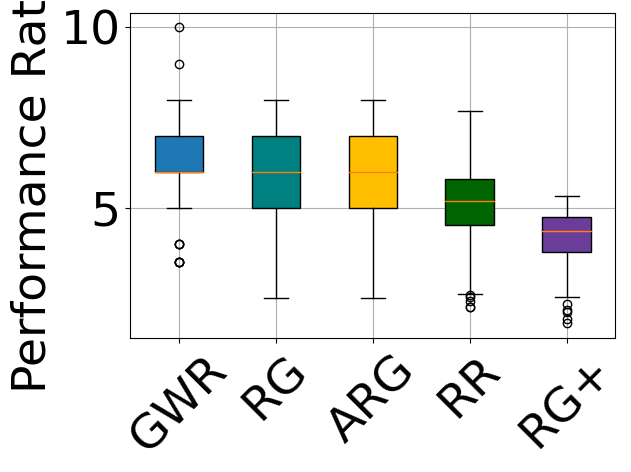

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

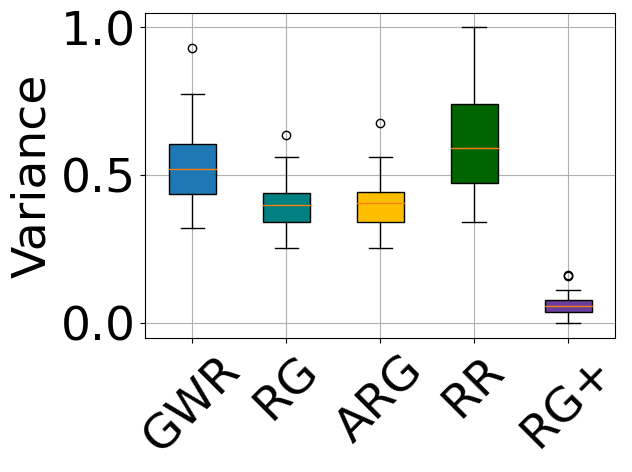

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

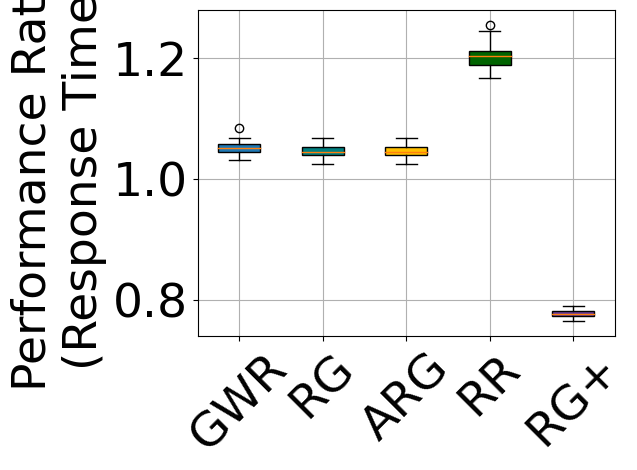

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,1000,1,50)
batch_test(BatchSet,1,0.3)
#GROUP1

Performance ratio
[('GWR', [6.5, 20.0, 12.0, 12.0, 14.0, 13.0, 10.0, 4.333333333333333, 5.5, 6.0, 12.0, 10.0, 12.0, 3.0, 10.333333333333334, 11.0, 7.0, 4.25, 17.0, 4.0, 12.0, 13.0, 10.0, 4.0, 4.333333333333333, 12.0, 13.0, 13.0, 14.0, 16.0, 11.0, 13.0, 14.0, 13.0, 10.0, 4.333333333333333, 12.0, 14.0, 4.333333333333333, 11.0, 3.3333333333333335, 5.0, 15.0, 17.0, 12.0, 18.0, 14.0, 11.0, 5.5, 17.0]), ('RG', [6.5, 14.5, 12.0, 10.0, 10.5, 11.0, 10.0, 3.6666666666666665, 4.5, 4.5, 9.0, 8.5, 10.5, 3.0, 12.0, 9.5, 6.75, 2.75, 17.5, 3.3333333333333335, 8.0, 12.5, 9.5, 3.0, 3.6666666666666665, 13.5, 12.0, 11.5, 11.0, 16.5, 10.5, 10.0, 14.5, 10.5, 8.0, 4.0, 11.5, 16.5, 3.8333333333333335, 11.5, 2.3333333333333335, 5.0, 15.0, 10.0, 8.0, 16.0, 11.5, 11.0, 6.0, 11.5]), ('ARG', [6.5, 14.5, 12.0, 10.0, 10.5, 11.0, 10.0, 3.6666666666666665, 4.5, 4.5, 9.0, 8.5, 10.5, 3.0, 12.0, 9.5, 6.75, 2.75, 17.5, 3.3333333333333335, 8.0, 12.5, 9.5, 3.0, 3.6666666666666665, 13.5, 12.0, 11.5, 12.0, 16.5, 10.5, 10.0, 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

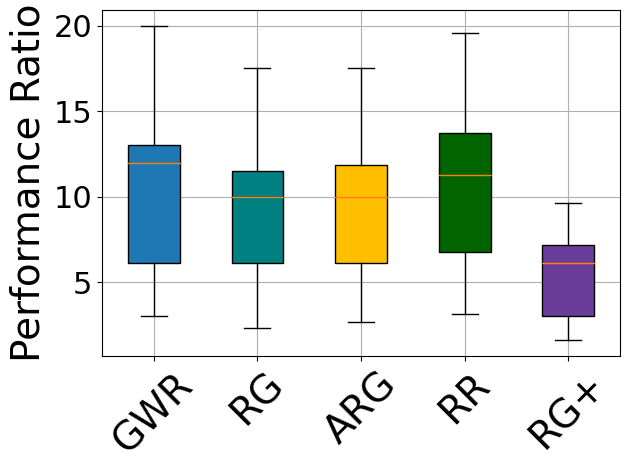

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

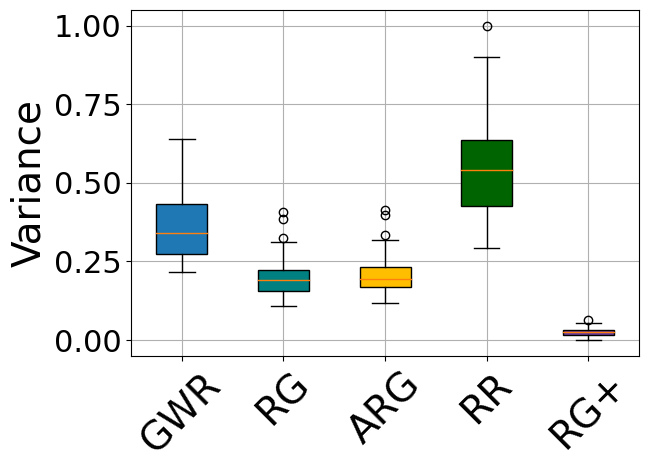

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

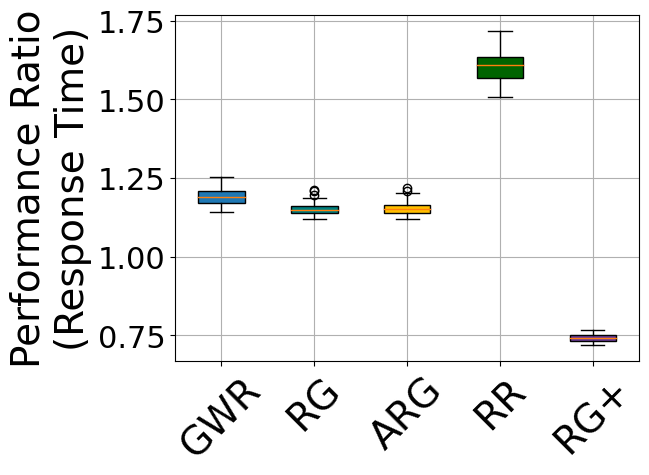

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,2000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('GWR', [5.333333333333333, 1.7, 15.0, 8.363636363636363, 41.0, 3.4444444444444446, 34.5, 33.0, 3.6818181818181817, 4.583333333333333, 6.666666666666667, 3.7142857142857144, 18.0, 12.666666666666666, 4.625, 3.1666666666666665, 32.5, 1.9428571428571428, 36.0, 10.8, 2.35, 46.0, 6.6, 3.75, 9.666666666666666, 2.409090909090909, 4.846153846153846, 3.0, 4.1, 2.6, 40.0, 4.777777777777778, 21.0, 2.8, 7.111111111111111, 55.0, 7.0, 5.833333333333333, 7.285714285714286, 5.636363636363637, 31.0, 6.0, 8.555555555555555, 1.7142857142857142, 7.428571428571429, 3.2, 10.75, 10.0, 33.0, 3.5]), ('RG', [5.0, 1.9, 16.0, 7.545454545454546, 50.0, 4.111111111111111, 29.25, 38.25, 3.590909090909091, 3.9583333333333335, 6.583333333333333, 3.0, 19.666666666666668, 12.75, 4.28125, 3.5, 26.25, 1.5714285714285714, 37.5, 11.9, 2.775, 48.5, 6.3, 3.2916666666666665, 10.0, 2.409090909090909, 5.269230769230769, 2.840909090909091, 4.2, 2.566666666666667, 41.0, 4.388888888888889, 23.5, 2.133333333333333

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

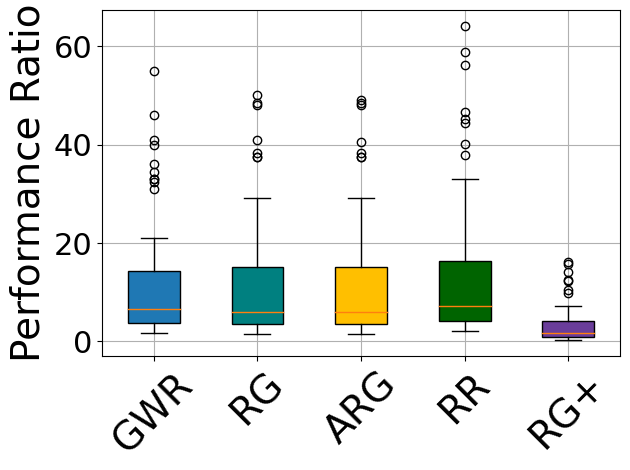

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

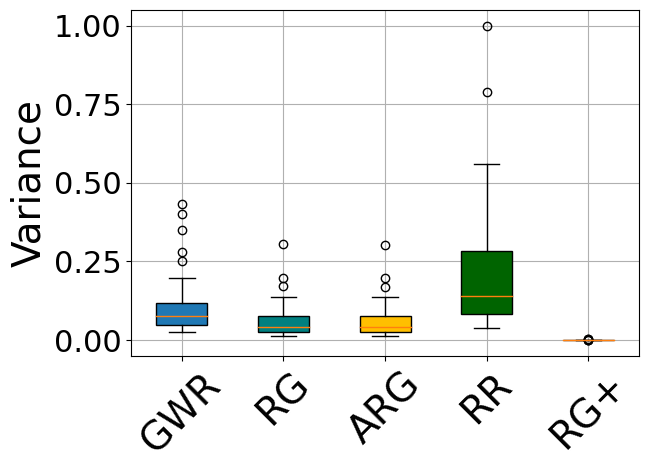

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

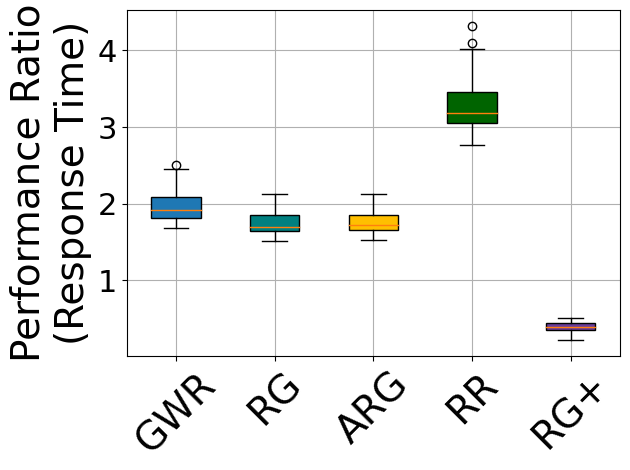

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,3000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [1.7754716981132075, 1.7274401473296501, 1.5249569707401032, 1.4929577464788732, 1.4835164835164836, 1.8676748582230625, 1.7176684881602915, 1.8342644320297952, 1.6962699822380107, 1.7607573149741824, 1.496309963099631, 1.8223443223443223, 1.7380952380952381, 1.7754318618042226, 1.868421052631579, 1.7338403041825095, 1.468864468864469, 1.6819012797074955, 1.845217391304348, 1.8232142857142857, 1.4369114877589453, 1.4765478424015008, 1.6654804270462633, 1.7760141093474426, 1.8552875695732838, 1.8669064748201438, 1.7122557726465364, 1.7541589648798521, 1.446927374301676, 1.843984962406015, 1.7673992673992673, 1.3891797556719023, 1.3520871143375681, 1.3918918918918919, 1.7028469750889679, 1.7843866171003717, 1.4192439862542956, 1.8266423357664234, 1.785063752276867, 1.6829268292682926, 1.5009174311926605, 1.4106194690265488, 1.8330241187384044, 1.775831873905429, 1.4554079696394686, 1.7961538461538462, 1.7844202898550725, 1.779270633397313, 1.7545787545787546, 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

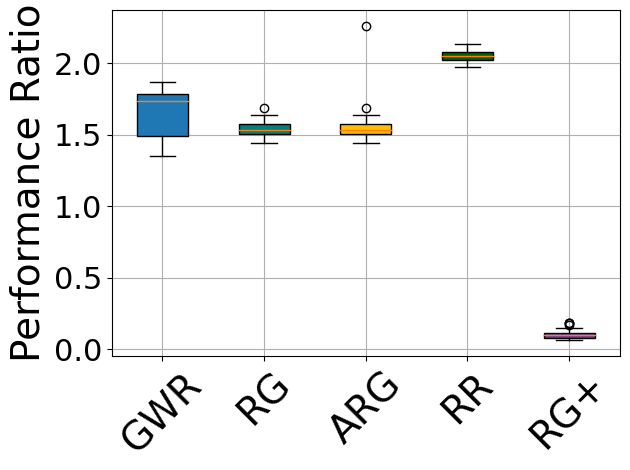

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

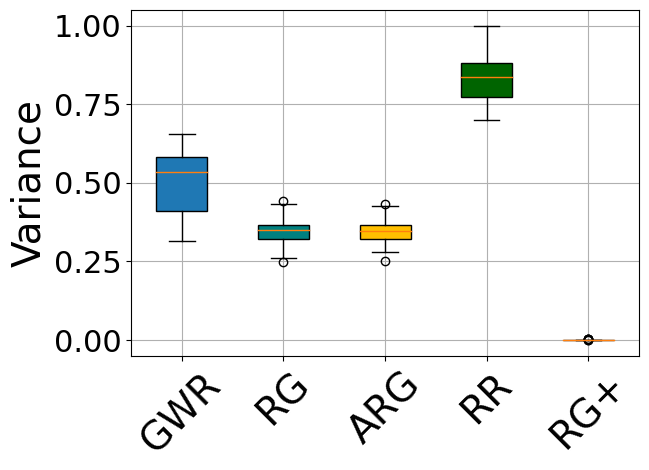

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

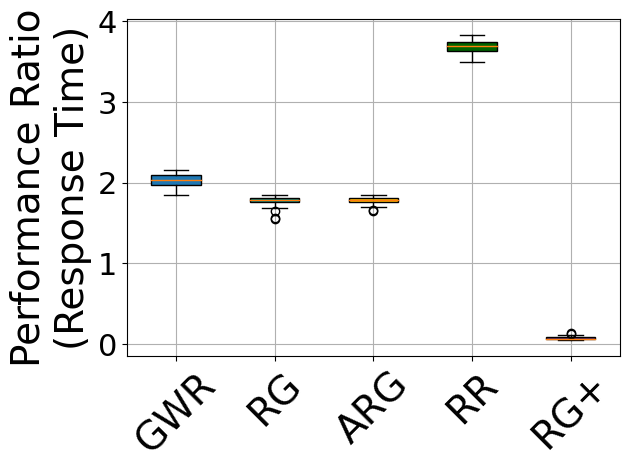

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,4500,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [1.8830297219558965, 1.8711832061068703, 1.4396551724137931, 1.828080229226361, 1.8357487922705313, 1.457674418604651, 1.8900473933649289, 1.9044465468306528, 1.8898385565052231, 1.47675568743818, 1.90205680705191, 1.8476190476190477, 1.9334619093539056, 1.9447186574531097, 1.458955223880597, 1.9217391304347826, 1.499031007751938, 1.8910614525139664, 1.5037735849056604, 1.8434442270058709, 1.8819119025304591, 1.4669187145557656, 1.8050682261208577, 1.8937381404174574, 1.9761194029850746, 1.9159584513692163, 1.9130434782608696, 1.8888888888888888, 1.8929889298892988, 1.961689587426326, 1.882865440464666, 1.4842707340324117, 1.7774647887323944, 1.8748815165876778, 1.8310546875, 1.8582020389249305, 1.5054187192118227, 1.92578125, 1.8996062992125984, 1.873405299313052, 1.9306083650190113, 2.0283553875236295, 1.8708765315739868, 1.4995196926032661, 1.7891156462585034, 1.908153701968135, 1.8975845410628018, 1.9216061185468452, 1.8971428571428572, 1.89413988657845])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

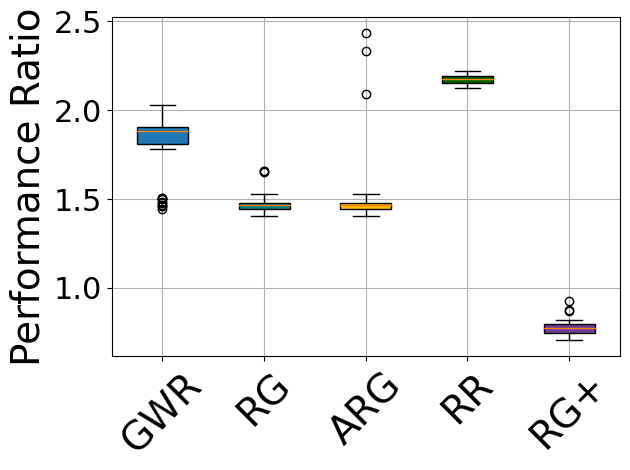

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

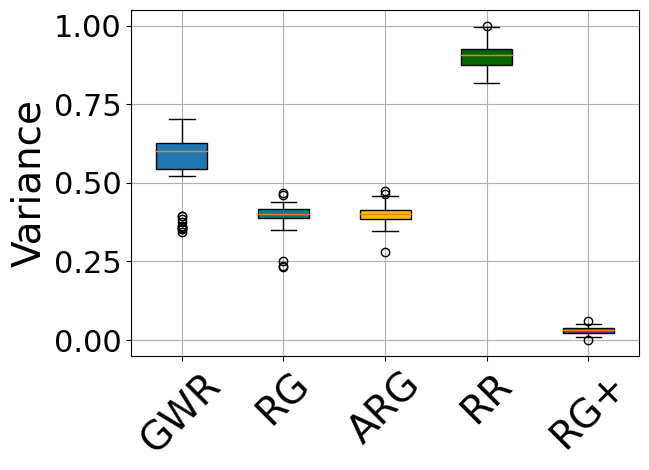

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

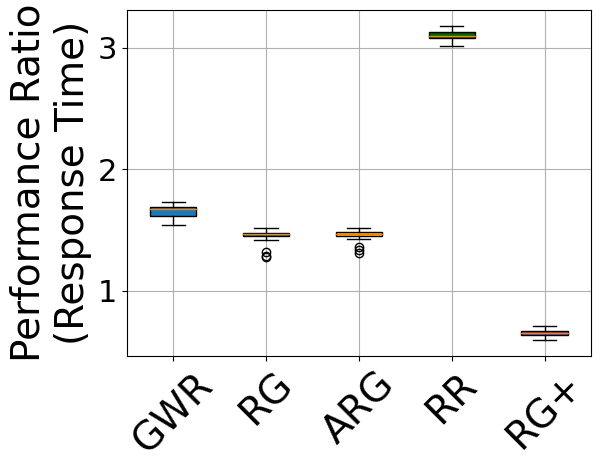

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,6000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [2.5161479741632413, 2.499558693733451, 2.475520375256523, 2.5108663292646622, 2.543154761904762, 2.5045601647543396, 2.5160246986180534, 2.508905109489051, 2.479870702321481, 2.51905041031653, 2.49573403942336, 2.5342992312241277, 2.5194957490472003, 2.520624631703005, 2.5427728613569323, 2.522957662492546, 2.524397413286302, 2.5026690391459074, 2.5077781039037275, 2.5379411764705884]), ('RG', [1.6089254257193188, 1.5884083553986466, 1.5768103195543828, 1.761536171479607, 1.6096726190476192, 1.5835539864666077, 1.5715965892384594, 1.6096350364963503, 1.5659712018806935, 1.5814771395076201, 1.5789938217122683, 1.6060023654642224, 1.584286133098798, 1.5894225103123159, 1.5870206489675516, 1.6238819320214668, 1.5983245149911816, 1.6055753262158956, 1.5864396830055767, 1.6139705882352942]), ('ARG', [1.6089254257193188, 1.8620182406590173, 1.5768103195543828, 1.6049419470080382, 1.6096726190476192, 1.5835539864666077, 1.5715965892384594, 1.6096350364963503, 1.565

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

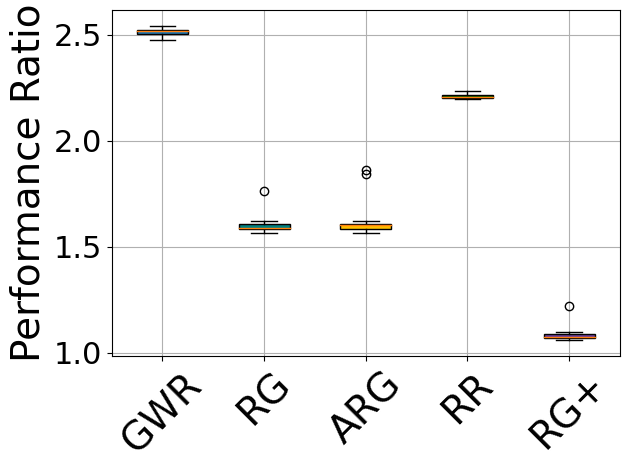

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

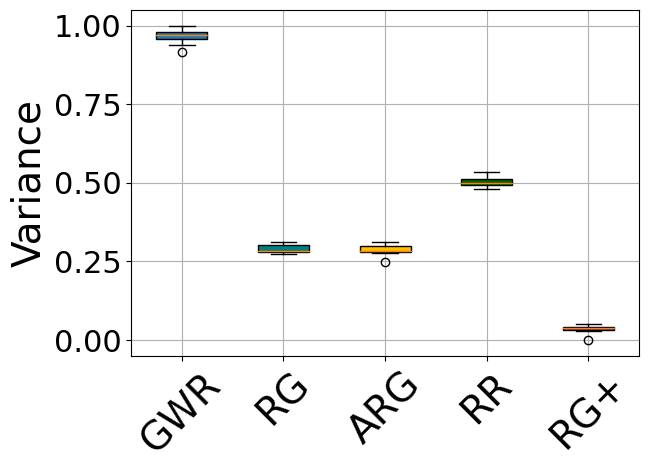

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

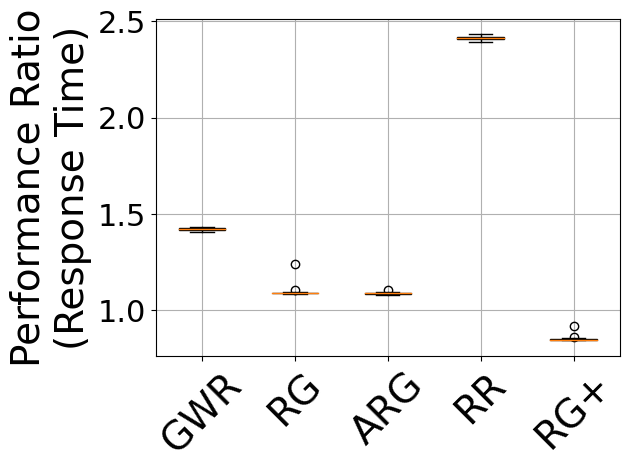

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,10000,1,50)
batch_test(BatchSet,1,0.3)

<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

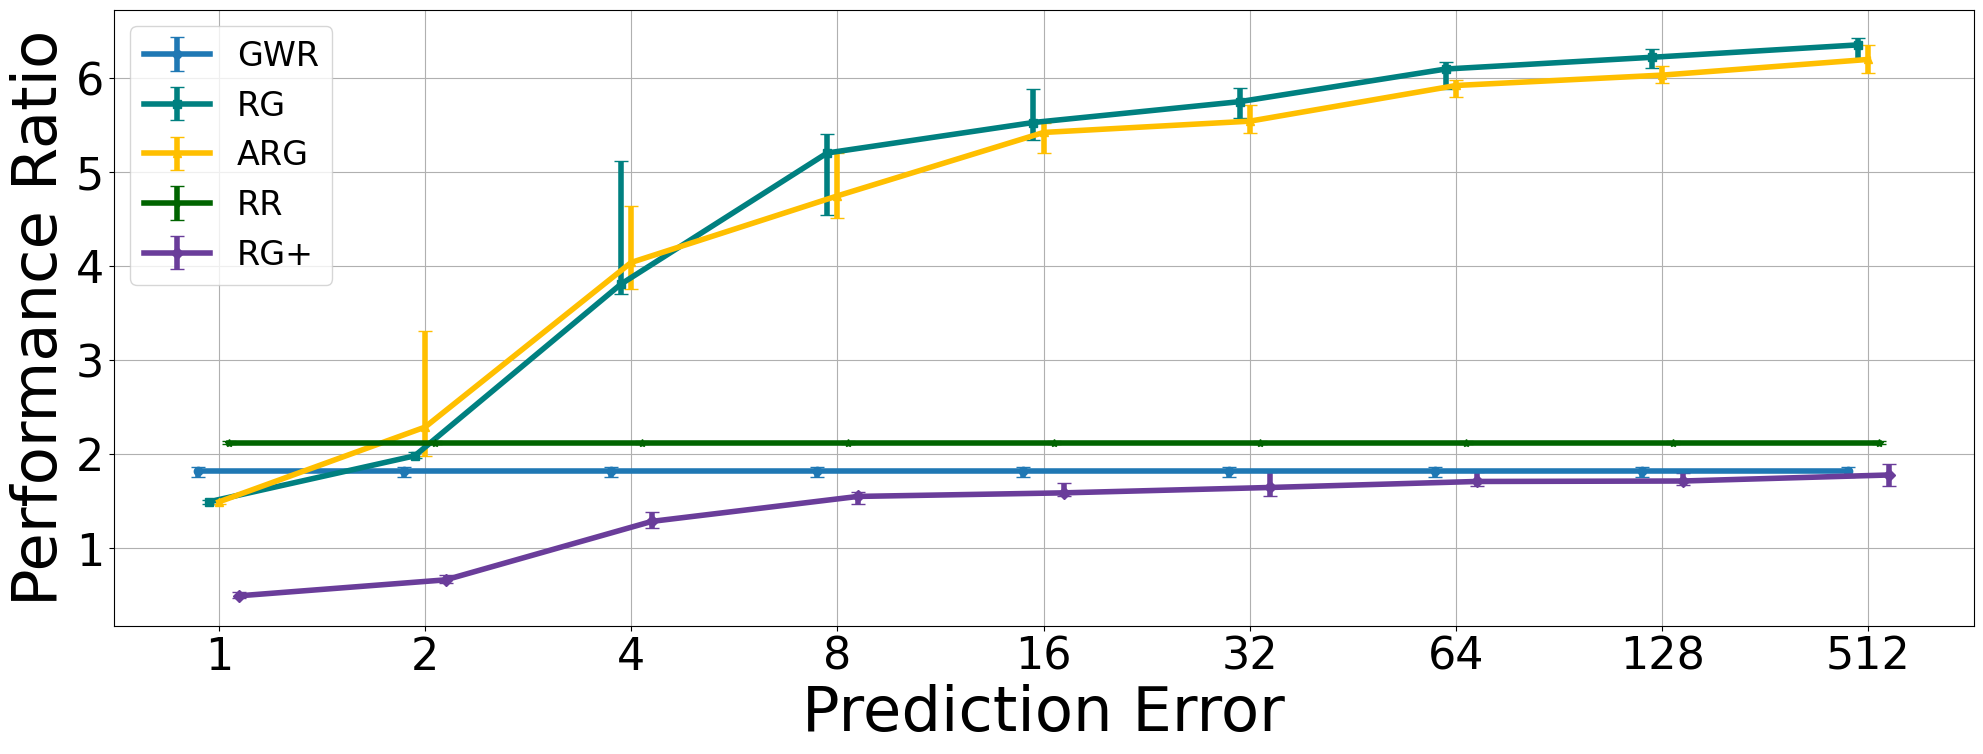

In [ ]:
S1_Data,V1_Data,R1_Data=[],[],[]
BatchSet=generateBatchLogJob(0,5000,1,4500,1,20)
batch_record(1,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,2)
batch_record(2,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,4)
batch_record(4,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,8)
batch_record(8,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,16)
batch_record(16,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,32)
batch_record(32,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,64)
batch_record(64,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,128)
batch_record(128,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,512)
batch_record(512,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
from sklearn.preprocessing import MinMaxScaler

s_df = pd.DataFrame(S1_Data)
draw_error_bar(s_df,"Max-Stretch Performance","Prediction Error","Performance Ratio")

<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

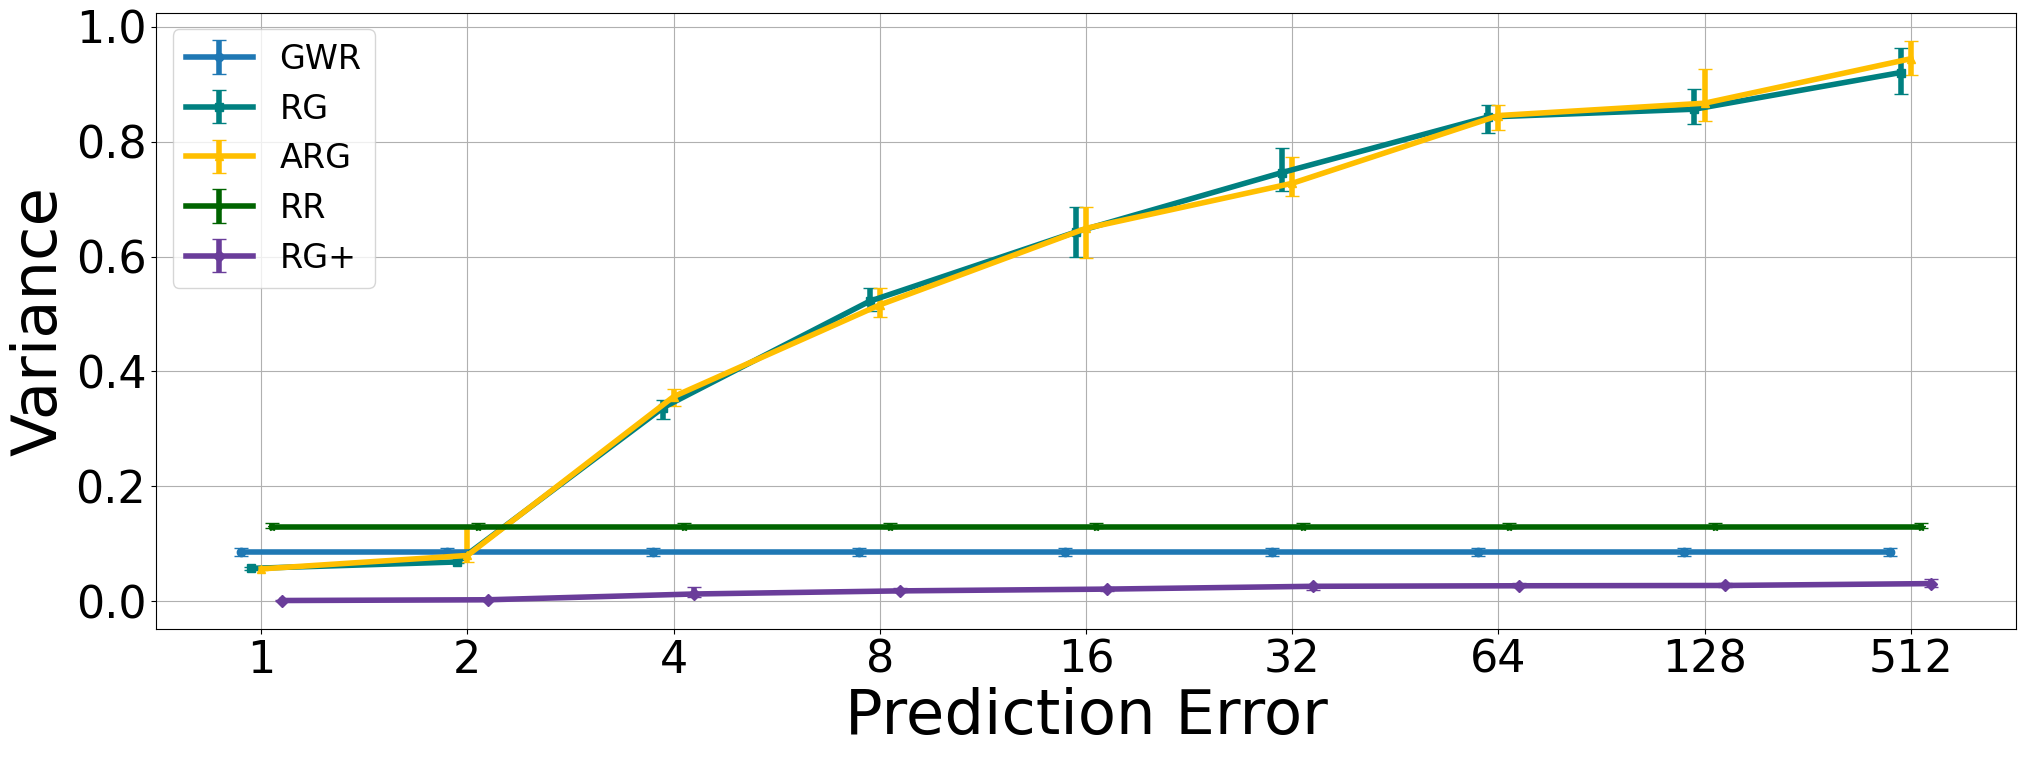

In [ ]:
v_df = pd.DataFrame(V1_Data)
scaler = MinMaxScaler()
v_df["Value"] = scaler.fit_transform(v_df[["Value"]])
draw_error_bar(v_df,"Variance","Prediction Error","Variance")

<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-21-2d1d919d5372>:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

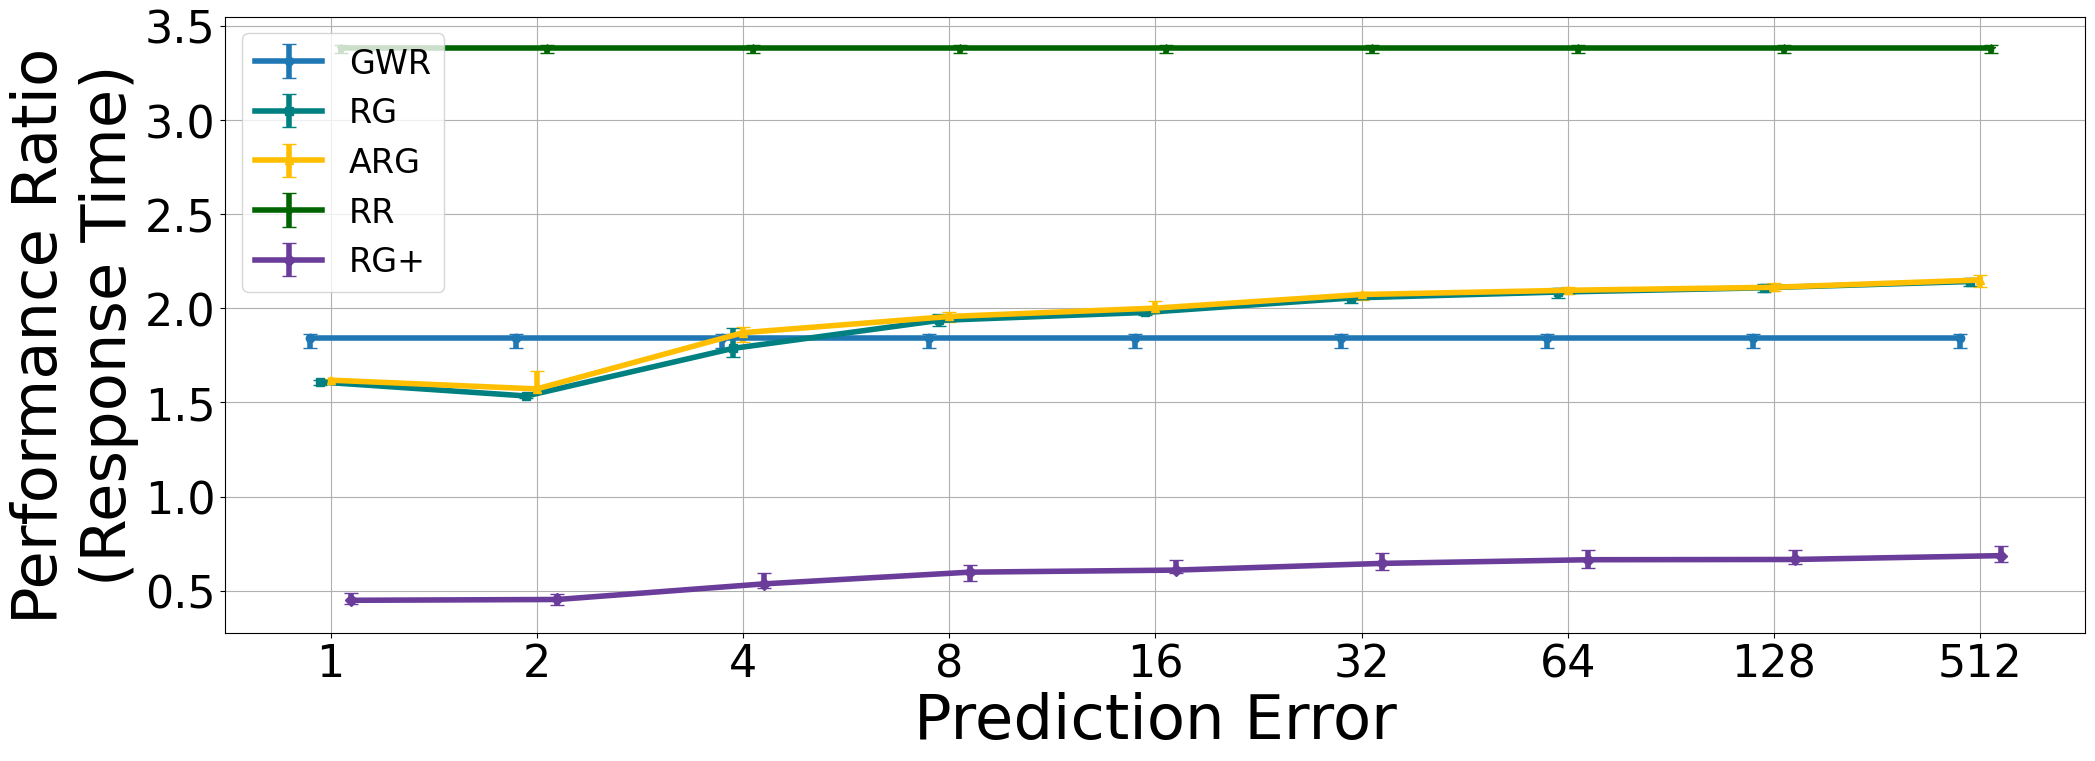

In [ ]:
r_df = pd.DataFrame(R1_Data)
draw_error_bar(r_df,"Average Response Time","Prediction Error","Performance Ratio \n(Response Time)")

In [ ]:
--------------------------------------

Performance ratio
[('GWR', [5.0625, 2.8484848484848486, 1.5272727272727273, 3.888888888888889, 3.4444444444444446, 1.8888888888888888, 1.5178571428571428, 3.411764705882353, 1.2391304347826086, 1.1833333333333333, 3.7916666666666665, 7.357142857142857, 2.4444444444444446, 1.68, 1.543859649122807, 1.3544303797468353, 2.2941176470588234, 1.9375, 1.32, 2.212121212121212, 2.108108108108108, 2.409090909090909, 5.333333333333333, 1.8333333333333333, 2.3846153846153846, 1.78125, 1.1927710843373494, 6.35, 1.375, 2.6666666666666665, 2.25, 1.65625, 3.466666666666667, 1.4102564102564104, 24.333333333333332, 1.9310344827586208, 4.909090909090909, 6.818181818181818, 1.186046511627907, 1.035294117647059, 1.1578947368421053, 9.75, 2.5833333333333335, 1.0810810810810811, 1.7105263157894737, 1.816326530612245, 2.3658536585365852, 2.25, 1.1973684210526316, 3.5416666666666665]), ('RG', [5.0625, 2.8484848484848486, 1.5272727272727273, 3.888888888888889, 3.4444444444444446, 1.8888888888888888, 1.5178571428

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

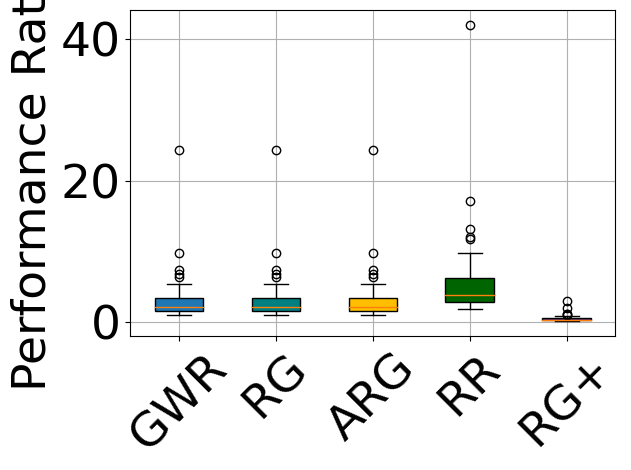

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

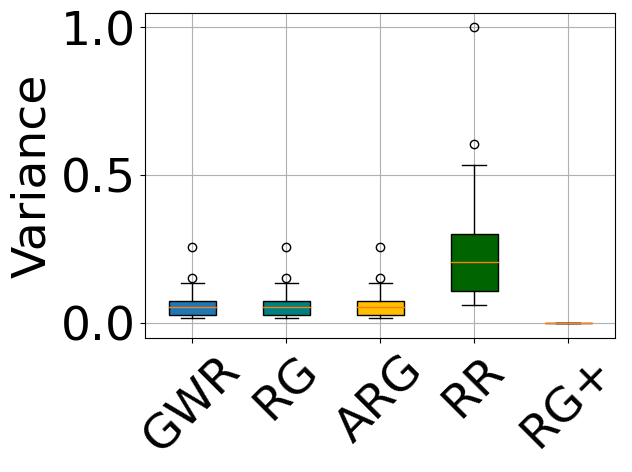

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

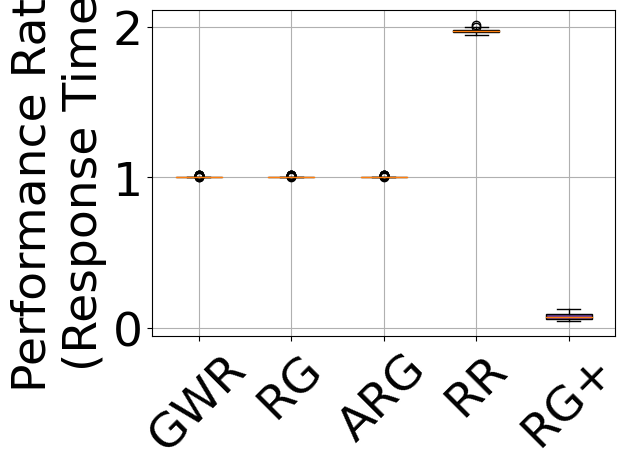

In [ ]:
BatchSet=generateBatchLogJob(0,5000,0.1,5000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('GWR', [1.0365384615384616, 1.0130841121495326, 1.0170132325141776, 1.0092936802973977, 1.0, 1.005586592178771, 1.0150093808630394, 1.036190476190476, 1.0115830115830116, 1.0, 1.0133079847908746, 1.0096339113680155, 1.0171102661596958, 1.0242085661080074, 1.0306513409961686, 1.013157894736842, 1.013157894736842, 1.018552875695733, 1.0267686424474187, 1.0148423005565863, 1.0246679316888045, 1.0134099616858236, 1.0055970149253732, 1.009469696969697, 1.0169172932330828, 1.0264650283553876, 1.0264650283553876, 1.0075901328273245, 1.0114068441064639, 1.0093808630393997, 1.003690036900369, 1.00375234521576, 1.0055452865064696, 1.011070110701107, 1.0074906367041199, 1.0193798449612403, 1.011111111111111, 1.0114068441064639, 1.0095057034220531, 1.005703422053232, 1.0224299065420561, 1.0075046904315197, 1.0112994350282485, 1.0, 1.0246212121212122, 1.0111524163568772, 1.0093632958801497, 1.0111940298507462, 1.0279329608938548, 1.0416666666666667]), ('RG', [1.0403846153846155,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

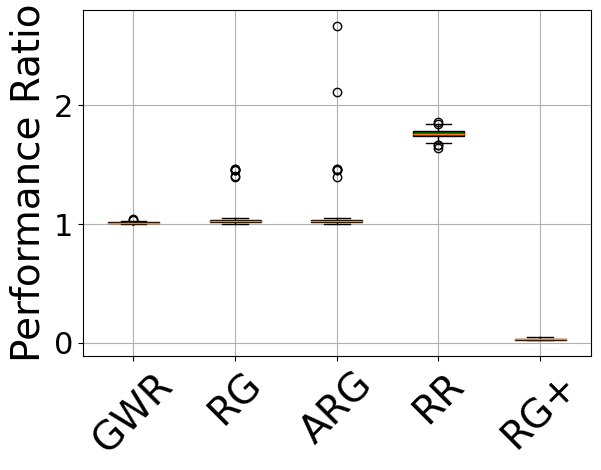

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

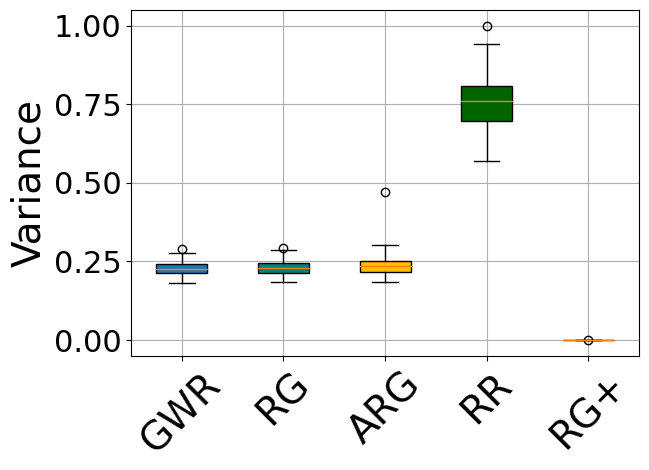

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

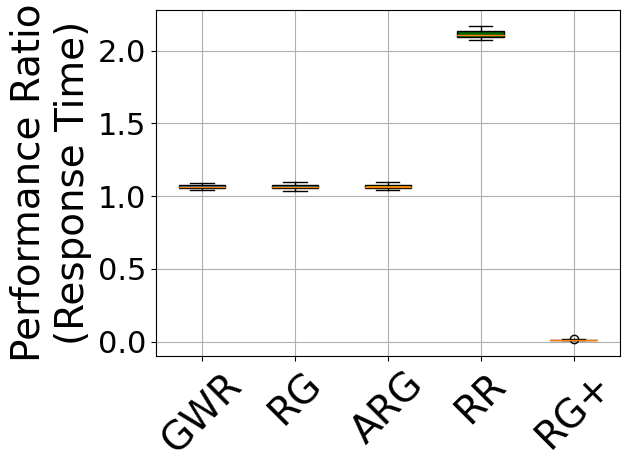

In [ ]:
BatchSet=generateBatchLogJob(0,5000,0.2,5000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('GWR', [1.212837837837838, 1.266441821247892, 1.219895287958115, 1.2725779967159276, 1.2372881355932204, 1.2864238410596027, 1.329090909090909, 1.2570480928689884, 1.2478777589134125, 1.3120567375886525, 1.314711359404097, 1.3079584775086506, 1.27008547008547, 1.2738095238095237, 1.2521008403361344, 1.3158813263525306, 1.3157894736842106, 1.2370129870129871, 1.2467320261437909, 1.2601054481546572, 1.2774869109947644, 1.2790697674418605, 1.2953367875647668, 1.2689655172413794, 1.260204081632653, 1.2762923351158646, 1.2597173144876326, 1.2996323529411764, 1.2618243243243243, 1.2667757774140753, 1.3101160862354893, 1.2976190476190477, 1.2857142857142858, 1.2336134453781513, 1.2366548042704626, 1.3070469798657718, 1.2298245614035088, 1.2650822669104205, 1.2552083333333333, 1.2844827586206897, 1.3516295025728988, 1.278829604130809, 1.2464285714285714, 1.270909090909091, 1.3016949152542372, 1.2947189097103917, 1.2696078431372548, 1.3038194444444444, 1.227027027027027, 1.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

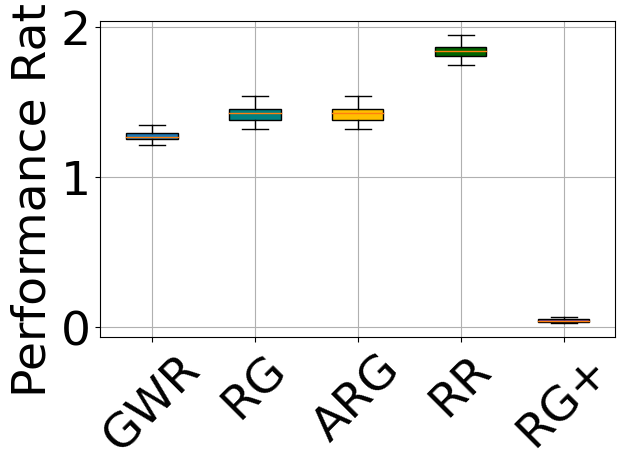

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

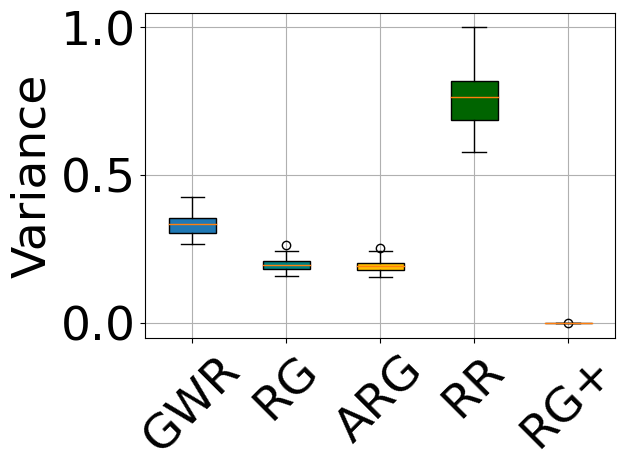

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

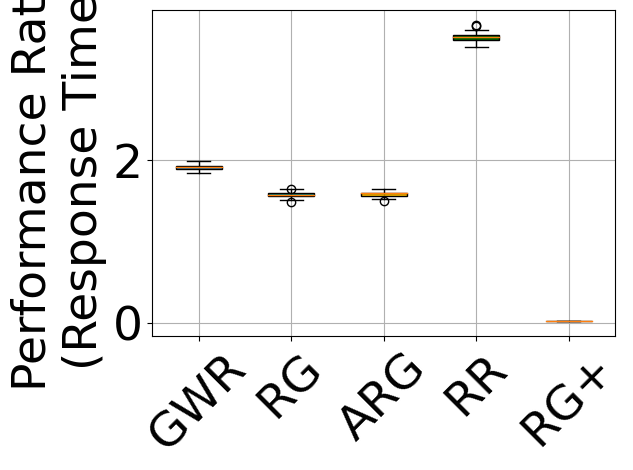

In [ ]:
BatchSet=generateBatchLogJob(0,5000,0.5,5000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('GWR', [1.793713163064833, 1.7572533849129595, 1.902738432483475, 1.458955223880597, 1.9200779727095516, 1.8620689655172413, 1.8236940298507462, 1.9566891241578441, 1.8432692307692307, 1.8026948989412896, 1.459000942507069, 1.46455938697318, 1.4741379310344827, 1.9605009633911368, 1.468146718146718, 1.9169054441260744, 1.8686481303930969, 1.843429636533085, 1.8493919550982227, 1.8621700879765395, 1.8901408450704225, 1.8767258382642997, 1.9036608863198459, 1.8234741784037558, 1.8772597526165558, 1.4550669216061185, 1.8375, 1.8575525812619502, 1.4575471698113207, 1.9056785370548603, 1.8028169014084507, 1.5135658914728682, 1.9239024390243902, 1.4770813844714688, 1.8160919540229885, 1.8450704225352113, 1.4688109161793372, 1.8746355685131195, 1.9129158512720157, 1.8979980934223069, 1.8005725190839694, 1.8334919124643196, 1.9424736337488016, 1.9427184466019418, 1.679886685552408, 1.538755980861244, 1.930740037950664, 1.8716216216216217, 1.9068673565380998, 1.8099808061420

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

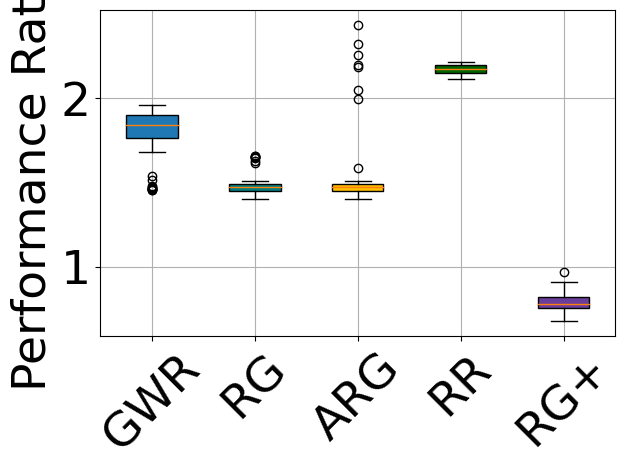

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

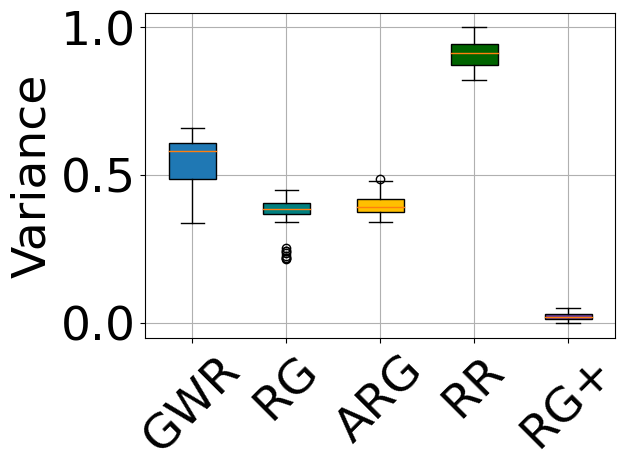

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

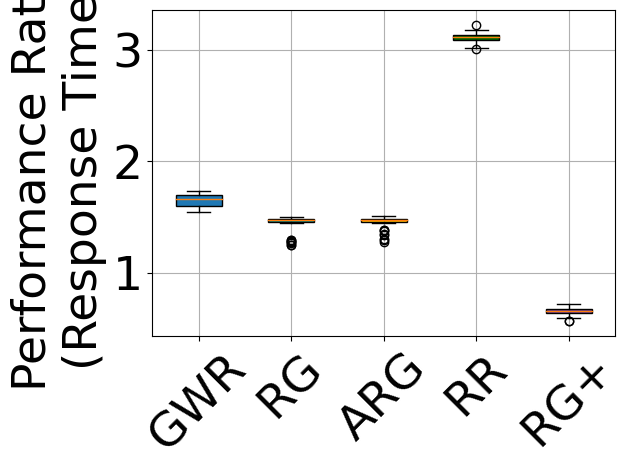

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,5000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [2.5888529886914378, 2.643867924528302, 2.7141744548286604, 2.6722354813046936, 2.6811023622047245, 2.5604395604395602, 2.5979462875197474, 2.6693227091633465, 2.6921259842519687, 2.573926868044515, 2.6413469068128426, 2.636937647987372, 2.581648522550544, 2.627279936558287, 2.6178343949044587, 2.65689381933439, 2.60224538893344, 2.541232986389111, 2.5382139983909897, 1.5559610705596107, 2.616588419405321, 1.509141494435612, 2.5827450980392155, 2.72, 2.5605095541401273, 2.661392405063291, 2.523543495610535, 3.727491961414791, 2.6378334680679063, 2.594896331738437, 2.604282315622522, 2.6408393866020985, 2.674565560821485, 2.591194968553459, 2.581320450885668, 2.6831604150039903, 2.5987606506584044, 2.611727416798732, 2.5945293644408687, 2.6551724137931036, 2.6056782334384856, 2.6040216550657385, 2.4908802537668517, 2.6457326892109503, 2.494901960784314, 2.58714859437751, 2.662348178137652, 2.6642216788916055, 2.6745283018867925, 2.5110410094637223]), ('RG', [2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

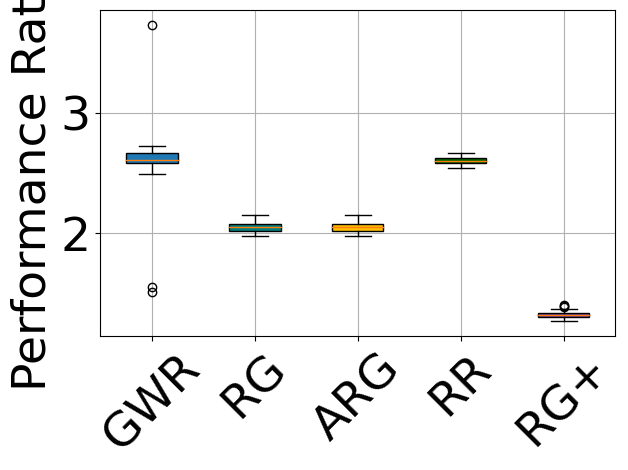

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

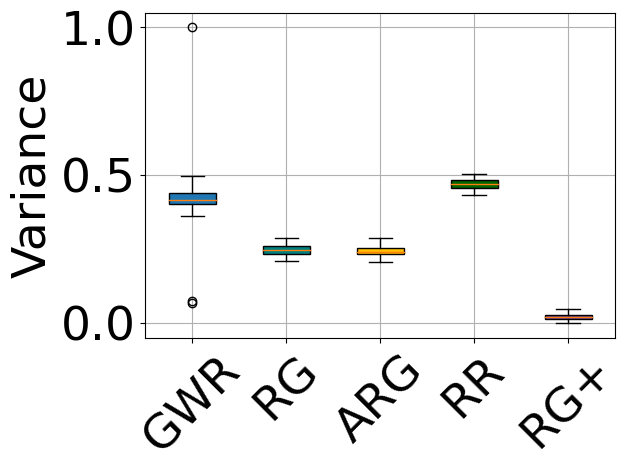

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

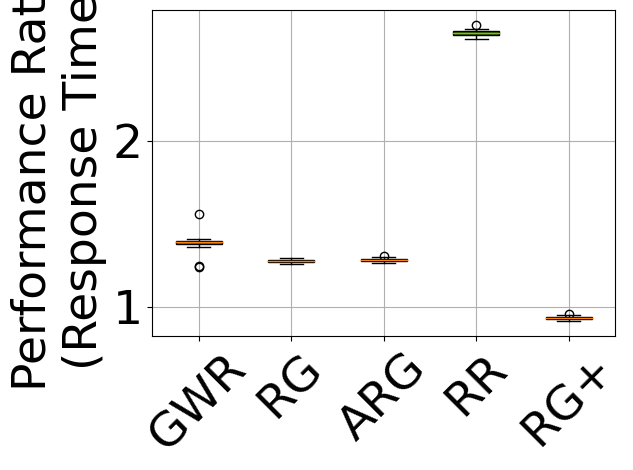

In [ ]:
BatchSet=generateBatchLogJob(0,5000,2,5000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [4.254843517138599, 2.8474331164135935, 2.962670495333812, 4.409425625920472, 4.143481427530954, 4.402777777777778, 5.5978021978021975, 2.8548387096774195, 4.243421052631579, 2.923076923076923, 4.351959361393324, 2.9338235294117645, 2.782041998551774, 2.976659372720642, 4.236511456023651, 2.8197548666186014, 2.953090096798213, 2.912490650710546, 4.43859649122807, 3.0752532561505066, 2.7948350071736012, 2.801598837209302, 2.8031088082901556, 4.225738396624473, 4.317126269956459, 2.8404726735598227, 4.2209043736100815, 4.3483727810650885, 4.245756457564576, 4.352549889135255, 4.1971428571428575, 3.123628383321141, 4.200145560407569, 2.8547445255474453, 2.911373707533235, 4.371641791044776, 4.337472607742878, 4.270622286541244, 2.8985401459854017, 4.298767222625091, 2.8306092124814266, 4.355506282335551, 4.362158167036216, 4.317777777777778, 2.9874074074074075, 2.9269911504424777, 3.032751091703057, 2.7624633431085046, 2.8687230989956958, 2.838038632986627]), ('

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

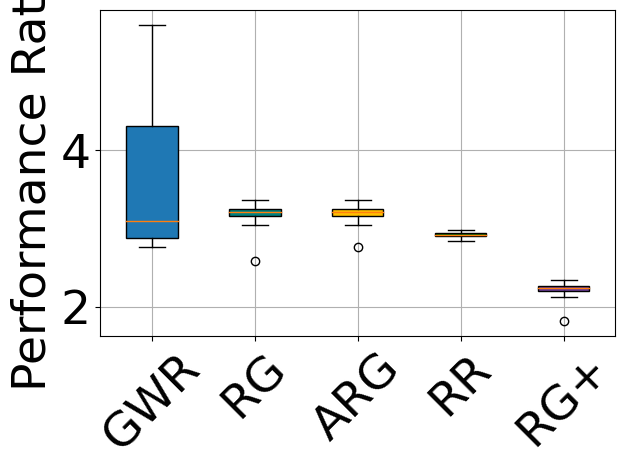

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

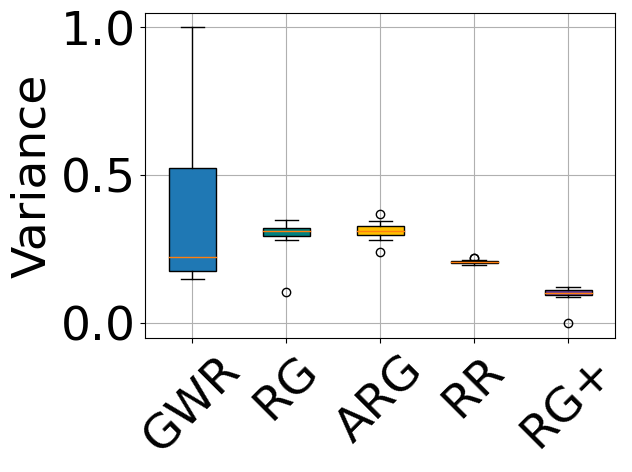

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

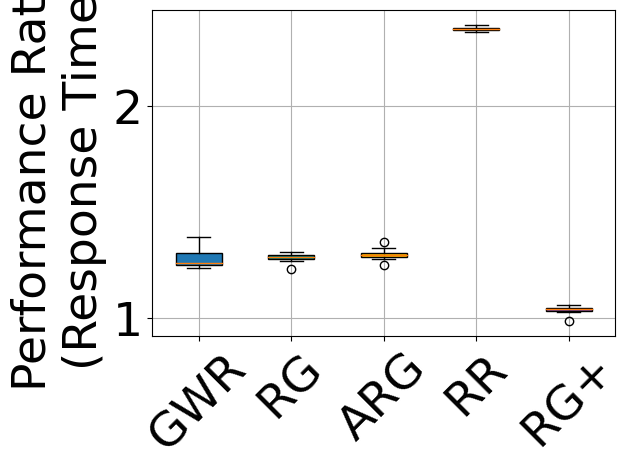

In [ ]:
BatchSet=generateBatchLogJob(0,5000,4,5000,1,50)
batch_test(BatchSet,1,0.3)



Performance ratio
[('GWR', [6.425694444444445, 5.145081387119603, 6.25515818431912, 4.921394395078606, 4.71509167842031, 4.8352272727272725, 4.98013698630137, 4.936886395511921, 4.8341497550734776, 5.152413793103448, 5.195467422096317, 5.026647966339411, 4.823405746320953, 4.871848739495798, 3.6334041047416843, 8.91880638445524, 5.249471458773784, 3.4726027397260273, 4.931914893617021, 5.13781163434903, 5.084757347915243, 5.016265912305516, 5.378435517970401, 4.924252953439889, 4.8268428372739915, 4.933797909407666, 5.061409630146546, 6.460406447091801, 5.119669876203576, 4.635932203389831, 4.893960674157303, 5.00416956219597, 3.9067321178120618, 5.0034746351633075, 6.227975790181573, 6.2512110726643595, 4.952586206896552, 6.457342657342657, 5.019176136363637, 4.964639321074965, 3.888571428571429, 7.275574112734864, 4.698347107438017, 5.128601546029515, 5.079633544749824, 5.087904360056259, 6.334739803094234, 5.160112359550562, 6.32202216066482, 3.860787172011662]), ('RG', [4.342013888

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

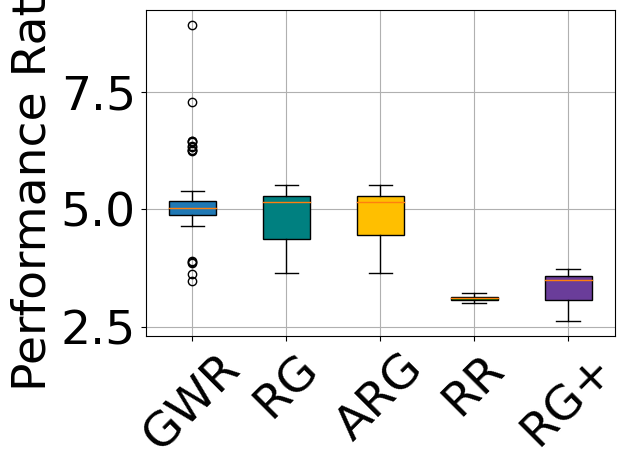

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

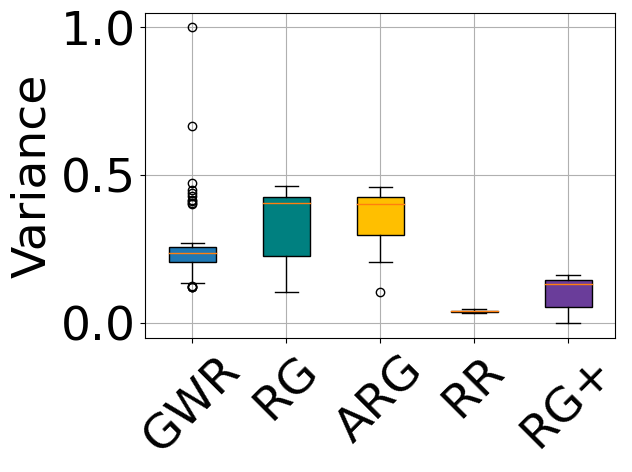

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

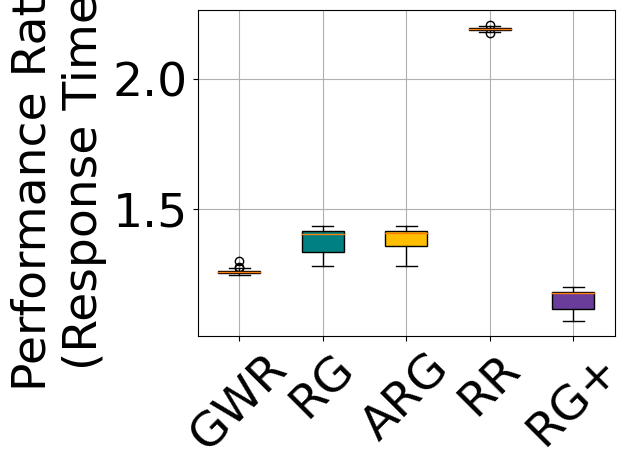

In [ ]:
BatchSet=generateBatchLogJob(0,5000,8,5000,1,50)
batch_test(BatchSet,1,0.3)

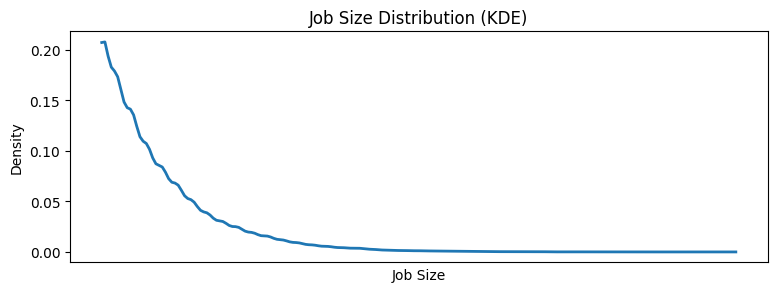

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from google.colab import files  # Importing files from google.colab

def job_distribute_visualise(BatchSet):
  BatchSet = generateBatchLogJob(0, 5000, 4, 1000, 1, 50)
  job_sizes = []
  for jobs in BatchSet:
      for j in jobs:
          job_sizes.append(j.jobSize)
  kde = gaussian_kde(job_sizes)
  smooth_job_sizes = np.linspace(min(job_sizes), max(job_sizes), 200)
  density = kde(smooth_job_sizes)
  plt.figure(figsize=(9, 3))
  plt.plot(smooth_job_sizes, density, linewidth=2)
  plt.xticks([])
  plt.ylabel('Density')
  plt.xlabel('Job Size')
  plt.title('Job Size Distribution (KDE)')
  filename = 'job_size_distribution.pdf'
  plt.savefig(filename, dpi=300)
  plt.show()
  files.download(filename)
job_distribute_visualise(BatchSet)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<ipython-input-15-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-15-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-15-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

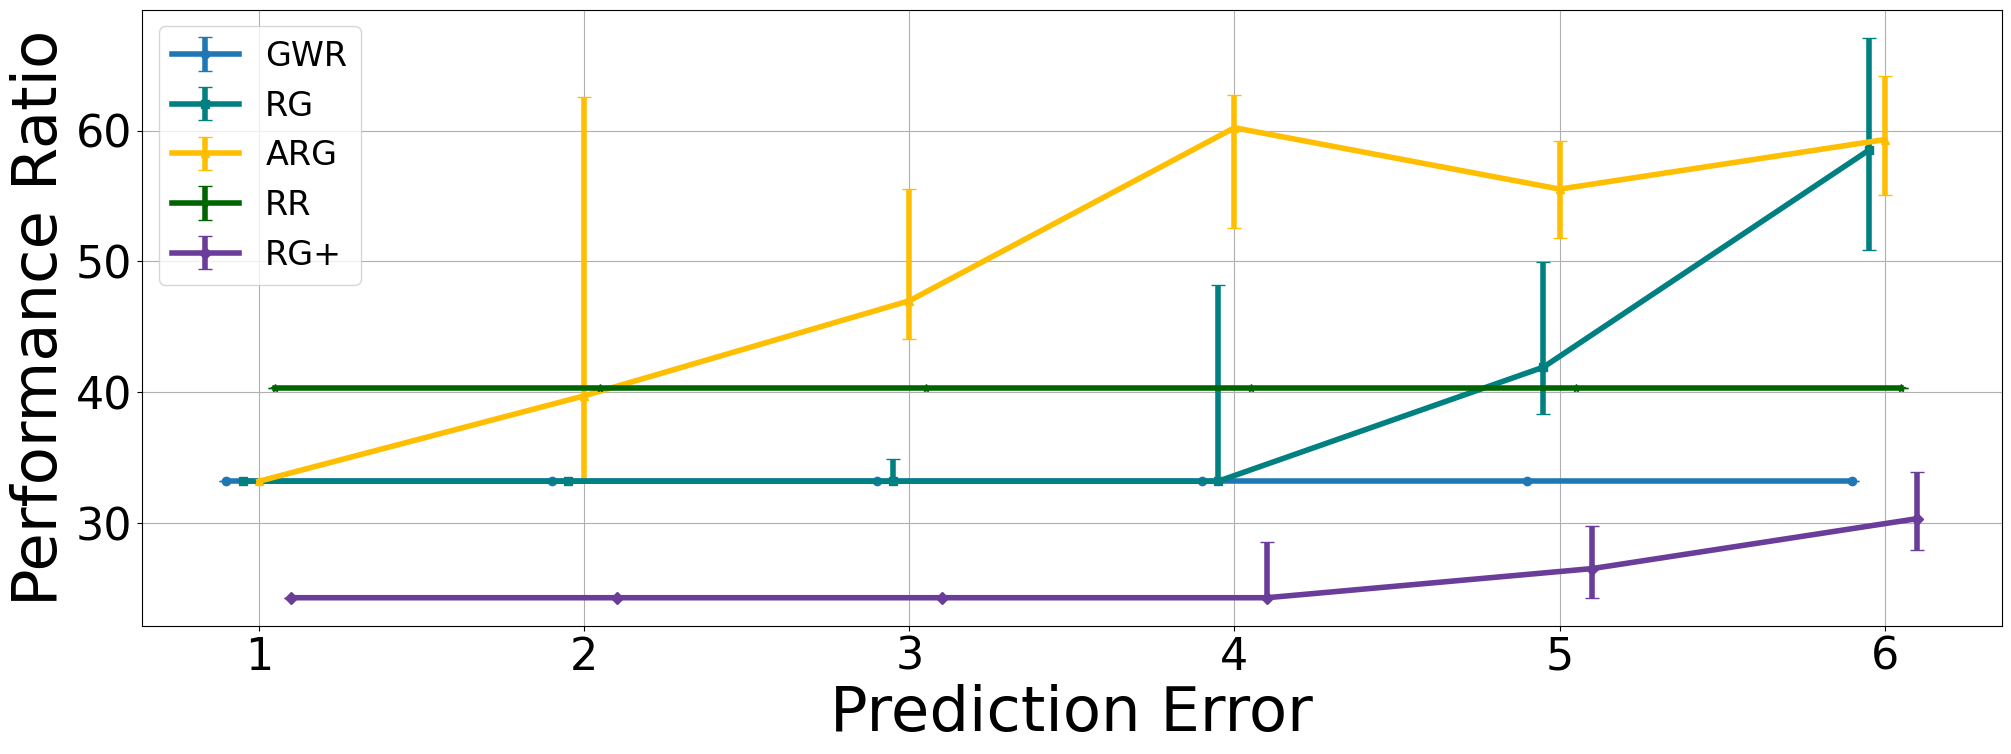

In [ ]:
import math
def ali_data(i_error):
  Batch_job_set = []
  for i in range(0, 20):
    test = []
    minimal_p = 99999999;
    maximal_p = 0;
    counter = 0
    target_max = 30
    f= open('/content/out_ali.csv')
    lines = f.readlines()
    for line in lines:
        if counter > 0:
          line = line.strip()
          dr = line.split(",")
          if int(round(float(dr[1]))) < minimal_p:
            minimal_p = int(round(float(dr[1])))
          if int(round(float(dr[1]))) > maximal_p:
            maximal_p = int(round(float(dr[1])))

          scaleJobSize = (int(round(float(dr[1])))-1)/880*(target_max-1)+1
          error_bound=math.log(i_error)
          error_i=random.uniform(-error_bound,error_bound)
          test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter, error_i])
        counter = counter + 1
    f.close()
    test = convert_jobs(test)
    Batch_job_set.append(test)
  return Batch_job_set

S2_Data,V2_Data,R2_Data=[],[],[]
BatchSet=ali_data(1)
batch_record(1,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(2)
batch_record(2,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(3)
batch_record(3,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(4)
batch_record(4,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(5)
batch_record(5,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(6)
batch_record(6,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
s_df = pd.DataFrame(S2_Data)
draw_error_bar(s_df,"Max-Stretch Performance ali","Prediction Error","Performance Ratio")

<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

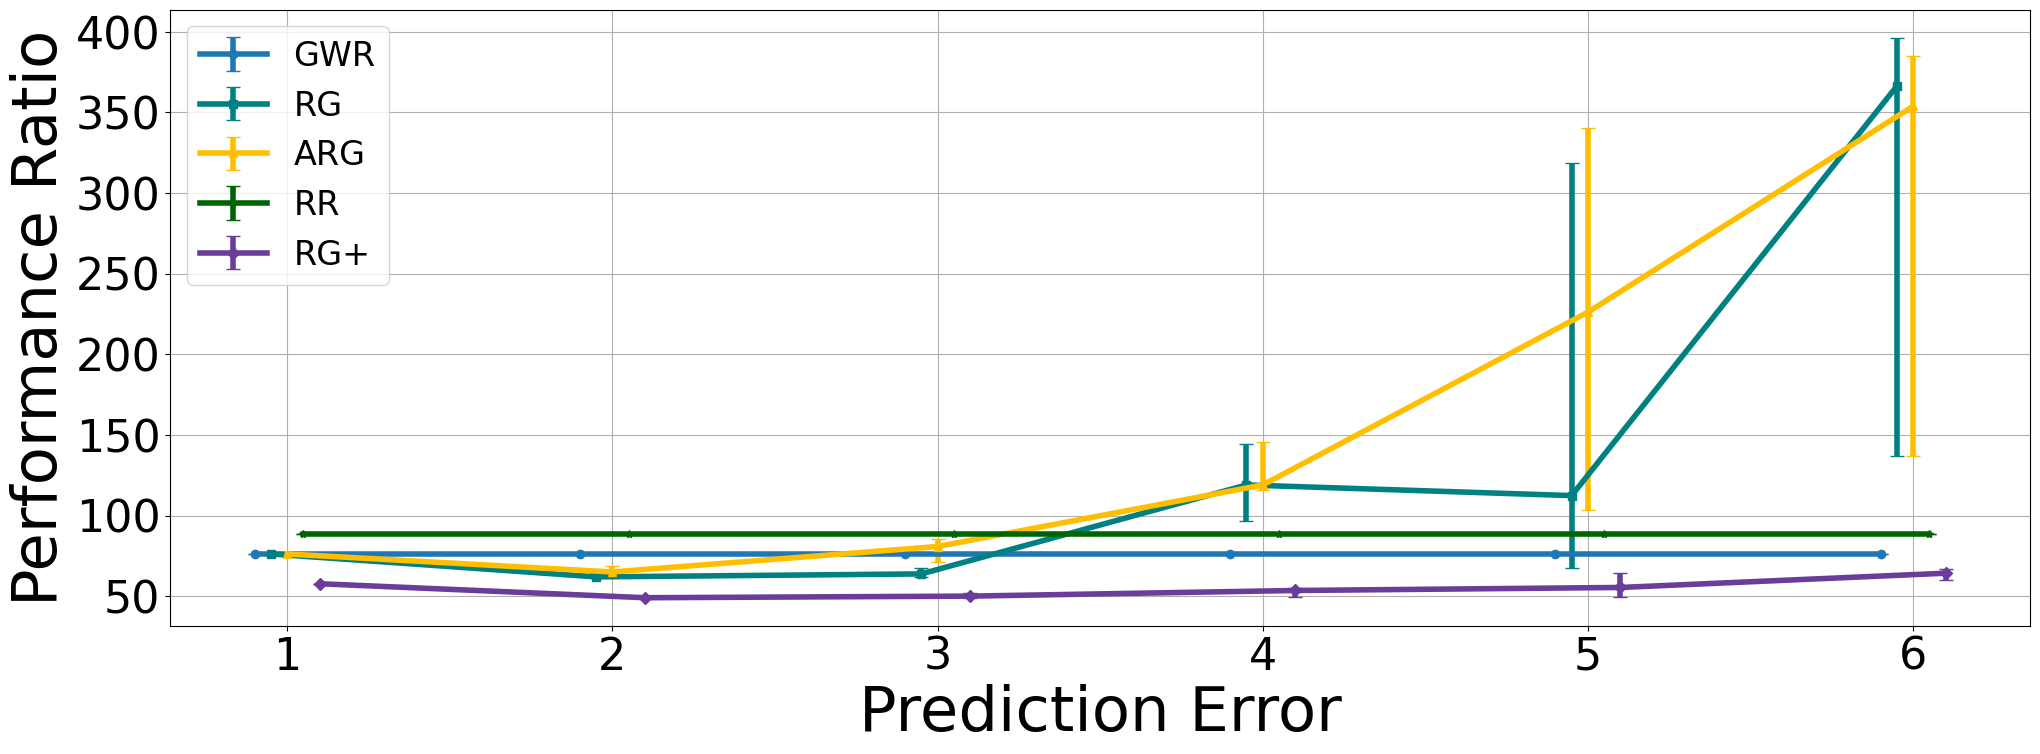

In [ ]:
import math
def azure_data(i_error):
  Batch_job_set = []
  for i in range(0, 20):
    test = []
    minimal_p = 99999999;
    maximal_p = 0;
    counter = 0
    target_max = 30
    f= open('/content/out_azure.csv')
    lines = f.readlines()
    for line in lines:
        if counter > 0:
          line = line.strip()
          dr = line.split(",")
          if int(round(float(dr[1]))) < minimal_p:
            minimal_p = int(round(float(dr[1])))
          if int(round(float(dr[1]))) > maximal_p:
            maximal_p = int(round(float(dr[1])))
          scaleJobSize = (int(round(float(dr[1])))-1)/259*(target_max-1)+1
          error_bound=math.log(i_error)
          error_i=random.uniform(-error_bound,error_bound)
          test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter,error_i])
        counter = counter + 1
    f.close()
    test = convert_jobs(test)
    Batch_job_set.append(test)
  return Batch_job_set


S2_Data,V2_Data,R2_Data=[],[],[]
BatchSet=azure_data(1)
batch_record(1,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(2)
batch_record(2,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(3)
batch_record(3,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(4)
batch_record(4,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(5)
batch_record(5,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(6)
batch_record(6,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
s_df = pd.DataFrame(S2_Data)
draw_error_bar(s_df,"Max-Stretch Performance azure","Prediction Error","Performance Ratio")


<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

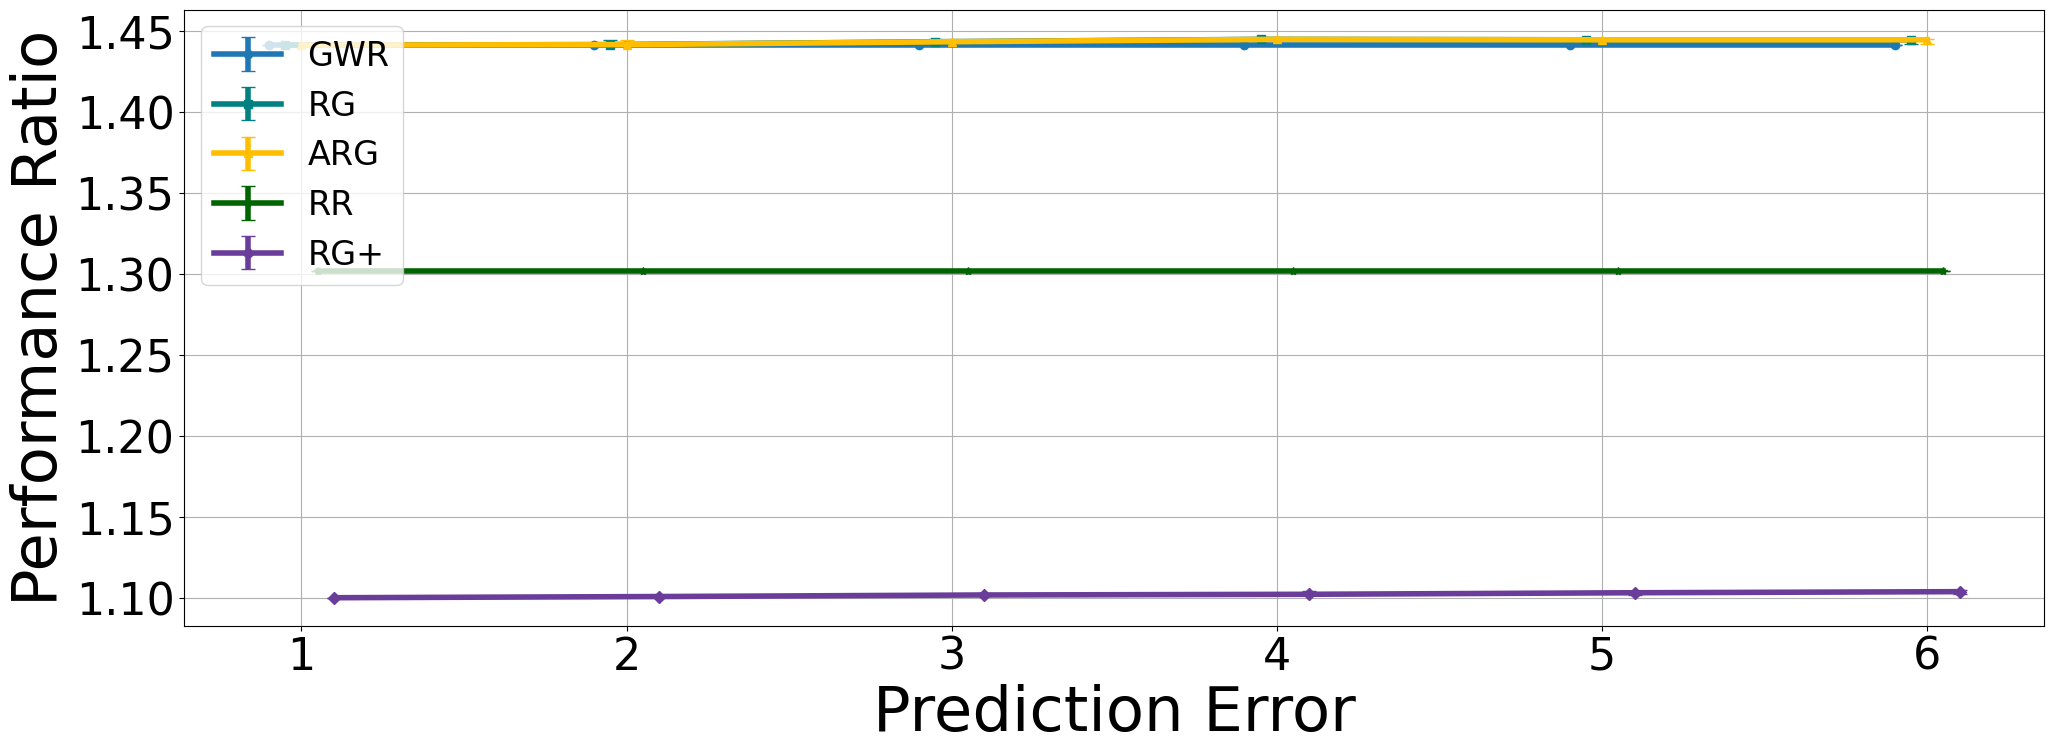

In [ ]:
import math
def google_data(i_error):
  Batch_job_set = []
  for i in range(0, 20):
    test = []
    minimal_p = 99999999;
    maximal_p = 0;
    counter = 0
    target_max = 50
    f= open('/content/out_google.csv')
    lines = f.readlines()
    for line in lines:
        if counter > 0:
          line = line.strip()
          dr = line.split(",")
          if int(round(float(dr[1]))) < minimal_p:
            minimal_p = int(round(float(dr[1])))
          if int(round(float(dr[1]))) > maximal_p:
            maximal_p = int(round(float(dr[1])))
          scaleJobSize = (int(round(float(dr[1])))-1)/(256128-1)*(target_max-1)+100
          error_bound=math.log(i_error)
          error_i=random.uniform(-error_bound,error_bound)
          test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter,error_i])
        counter = counter + 1
    f.close()
    test = convert_jobs(test)
    Batch_job_set.append(test)
  return Batch_job_set

S2_Data,V2_Data,R2_Data=[],[],[]
BatchSet=google_data(1)
batch_record(1,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(2)
batch_record(2,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(3)
batch_record(3,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(4)
batch_record(4,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(5)
batch_record(5,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(6)
batch_record(6,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
s_df = pd.DataFrame(S2_Data)
draw_error_bar(s_df,"Max-Stretch Performance google","Prediction Error","Performance Ratio")